Import packages

In [1]:
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from scipy.stats.mstats import gmean
from sklearn import covariance
from sklearn.preprocessing import normalize

import sys
import os
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pickle
import random
from collections import defaultdict
from scipy import stats
from tqdm import tqdm
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed


Initial data wrangling

In [2]:
def process_data(otu_file_path, metadata_file_path, distance_matrix_file_path=None, 
                 sample_id='Sample', condition_id='Study.Group', phylo=False):
    
    """Processes OTU table, metadata, and optionally a phylogenetic (or otherwise) distance matrix."""
    
    sep_otu = '\t' if otu_file_path.endswith('.tsv') else ','
    sep_meta = '\t' if metadata_file_path.endswith('.tsv') else ','
    
    otu_table = pd.read_csv(otu_file_path, index_col=0, sep=sep_otu)
    metadata = pd.read_csv(metadata_file_path, sep=sep_meta)
    
    if sample_id not in metadata or condition_id not in metadata:
        raise ValueError("Missing required columns in metadata.")
    
    metadata.set_index(sample_id, inplace=True)
    common_samples = otu_table.index.intersection(metadata.index)
    
    otu_table = otu_table.loc[common_samples]
    metadata = metadata.loc[common_samples]
    
    otu_table = otu_table.loc[:, (otu_table != 0).any(axis=0)]  # Drop all-zero columns
    otu_table = otu_table.div(otu_table.sum(axis=1), axis=0)  # Normalize to get relative abundances
    
    otu_table_grouped = otu_table.groupby(metadata[condition_id]).mean()
    
    phylo_distances = None
    if phylo and distance_matrix_file_path:
        phylo_distances = pd.read_csv(distance_matrix_file_path, index_col=0)
        phylo_distances = phylo_distances.loc[otu_table.columns, otu_table.columns].to_numpy()
    
    metadata['condition'] = metadata.index.str[0] + '-' + metadata[condition_id].astype(str)
    #metadata.index = metadata['condition']
    #otu_table.index = metadata.index
    
    return otu_table, metadata, phylo_distances, metadata['condition'].to_numpy(), otu_table_grouped

feature_table, metadata, phylo_distances, labels, otu_table_grouped = process_data(
    "/Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/OTU_table.csv",
    "/Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/metadata.tsv", 
    sample_id='Sample-ID', condition_id='Group ID'
)

feature_table.head()


,000542c8b5f1e84456c00f2a31ff2e5c,a534dd4959a8a823a499b837b709715b,4c9939a93db7b14a028245155492ac8e,aca4d218ca812c0421b3c8709895e90c,d294afbdfe8e32d772413bcae59257b7,77cfd84b41bc7a823d2fd3a07720f630,6639c219ee15084dad8de89c81d44743,c684492de5864e145aec85ba05996dce,a7ebbb1185a05884eb1f058a51a5a9f1,5aa81c4f07a78cffd5a3c235982cc88d,...,a0bded2b30070209e19bcdc9d47d2081,72d886315a5c7b9f02f8f19ea083d30b,3194a7a0b76e6688ad149980c3e556cc,f27cf7196efd3065029265a3550a31cc,ae978e65d6bf95e056983eec6feb4cef,bc7596a48a79d815b0ebe2a9421583b1,b6c24e652e819aca2a529eb68c689452,47892ef739987064f592b8525bb99c1d,f544fec8e6156c817bde06b9303ffbac,687a887797cbe32633fe89f3e7b45157
T1-1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.015140,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
T1-10,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000309,...,0.014302,0.0,0.0,0.0,0.001891,0.006267,0.0,0.0,0.0,0.0
T1-2,0.0,0.0,0.0,0.009635,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.003689,0.0,0.0,0.0,0.000000,0.001032,0.0,0.0,0.0,0.0
T1-3,0.0,0.0,0.0,0.005251,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.046213,0.0,0.0,0.0,0.005774,0.003280,0.0,0.0,0.0,0.0
T1-4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [ ]:

# Compute sample weights for each sample
def compute_sample_weights(sample_rel_otu):
    binary_sample = [1 if num != 0 else 0 for num in sample_rel_otu]
    sample_binary_matrix = np.outer(binary_sample, binary_sample)
    sample_matrix = np.tile(sample_rel_otu, (len(sample_rel_otu), 1))
    
    original_array = np.diag(sample_matrix)
    non_zero_mask = original_array != 0
    inverted_non_zero_elements = 1 / original_array[non_zero_mask]
    result_array = np.zeros_like(original_array, dtype=float)
    result_array[non_zero_mask] = inverted_non_zero_elements
    inv_diag = np.diag(result_array)
    
    ratios = np.matmul(inv_diag, sample_matrix)
    weights = np.add(np.triu(ratios, k=1), np.tril(ratios, k=-1).T)
    non_zero_mask = weights != 0
    reciprocal_non_zero_elements = 2 / weights[non_zero_mask]
    weights[non_zero_mask] = reciprocal_non_zero_elements
    weights_new = np.add(np.triu(weights, k=1), np.triu(weights, k=-1).T)
    
    return weights_new, sample_binary_matrix

# Compute weights for all samples
def compute_all_weights(raw_data):
    relative_raw = normalize(raw_data, axis=1, norm='l1')
    combined_weights = np.zeros((len(raw_data[0]), len(raw_data[0])))
    cooc_matrix = np.zeros((len(raw_data[0]), len(raw_data[0])))
    
    for sample in relative_raw:
        w, cooc = compute_sample_weights(sample)
        combined_weights += w
        cooc_matrix += cooc

    cooc_matrix_with_ones = np.where(cooc_matrix == 0, 1, cooc_matrix)
    final_matrix = np.divide(combined_weights, cooc_matrix_with_ones)
    
    return final_matrix, cooc_matrix

# Create bootstrap samples
def create_bootstrap_population(observed_data, n=100, condition_group="Control", output_dir="../outputs/bstrap_results"):
    if condition_group not in labels:
        raise ValueError("Invalid condition group")
    
    print(f"Bootstrapping {n} samples for condition: {condition_group}")
    directory = f"{output_dir}/bstrap_results_{condition_group}"
    os.makedirs(f"{directory}/matrices", exist_ok=True)
    
    raw_data = observed_data.to_numpy()
    bstrap_otus = [raw_data[np.random.randint(0, len(raw_data), len(raw_data))] for _ in range(n)]
    
    def process_bootstrap_sample(b, otu_sample):
        w, _ = compute_all_weights(otu_sample)
        np.savetxt(f"{directory}/matrices/bstrap_weight_matrix_{b}.csv", w)
        return w.flatten()
    
    results = Parallel(n_jobs=-1)(delayed(process_bootstrap_sample)(b, otu) for b, otu in enumerate(bstrap_otus))
    
    bstrap_means = np.mean(results, axis=0)
    bstrap_stds = np.std(results, axis=0)
    np.savetxt(f"{directory}/_means_{condition_group}.csv", bstrap_means)
    np.savetxt(f"{directory}/_stds_{condition_group}.csv", bstrap_stds)


def filtering_pvals_for_each_sample(df_cond, condition_group, thresh=0.1, output_dir="../outputs/bstrap_results"):
    directory = f"{output_dir}/bstrap_results_{condition_group}/matrices/"
    unfiltered_matrices_dir = f"{output_dir}/unfiltered_matrices/"
    os.makedirs(unfiltered_matrices_dir, exist_ok=True)
    
    filtered_matrices_dir = f"{output_dir}/filtered_matrices/"
    os.makedirs(filtered_matrices_dir, exist_ok=True)
    filtered_graphs_dir = f"{output_dir}/filtered_graphs/"
    os.makedirs(filtered_graphs_dir, exist_ok=True)  

    # Load bootstrap results
    files = [np.loadtxt(directory + f) for f in os.listdir(directory)]
    data_cond = df_cond.to_numpy()
    
    # Track species presence
    species_occur = np.count_nonzero(data_cond, axis=0)
    species_appear = np.where(species_occur > 0)[0]
    species_appear_names = df_cond.columns[species_appear]
    
    # Dictionary to store bootstrap results for each edge
    bs_cdf = defaultdict(list)
    for dat in files:
        for i, j in zip(*np.triu_indices(dat.shape[0], k=1)):
            bs_cdf[i, j].append(dat[i, j])

    for k in bs_cdf:
        bs_cdf[k].sort()

    # Normalize the data (relative abundance)
    rel_ab = data_cond / data_cond.sum(axis=1, keepdims=True)
    
    # Dictionary to store filtering summary per sample
    filtering_summary_info = {}

    # Create a copy of the OTU table to store filtered values
    filtered_otu_table = df_cond.copy()

    # Process each sample
    for counter, da in enumerate(data_cond):
        sample_name = df_cond.index[counter]
        filtering_summary_info[sample_name] = {}  # Store info per sample
        
        nodes_in = np.count_nonzero(da)
        filtering_summary_info[sample_name]["nodes_in"] = nodes_in

        sample_weights = compute_sample_weights(da)[0]
        unfiltered_matrix_path = f"{unfiltered_matrices_dir}weights_{sample_name}.csv"
        np.savetxt(unfiltered_matrix_path, sample_weights, delimiter=",")

        total_edges = 0
        filtered_edges = 0  

        for i, j in zip(*np.triu_indices(sample_weights.shape[0], k=1)):
            if sample_weights[i, j] > 0:
                total_edges += 1
                
                if (i, j) in bs_cdf and len(bs_cdf[i, j]) > 1:
                    bs = bs_cdf[i, j]
                    mean_w, std_w = np.mean(bs), np.std(bs)
                    
                    if std_w > 0:
                        _, p_val = stats.ttest_1samp(bs, popmean=sample_weights[i, j], alternative='two-sided')
                    else:
                        p_val = 1.0  

                    if p_val < thresh:
                        sample_weights[i, j] = sample_weights[j, i] = 0
                        filtered_edges += 1

        filtering_summary_info[sample_name]["edges_in"] = total_edges
        filtering_summary_info[sample_name]["edges_filtered"] = filtered_edges
        filtering_summary_info[sample_name]["prop_filtered"] = (
            filtered_edges / total_edges if total_edges > 0 else 0
        )

        filtered_matrix_path = f"{filtered_matrices_dir}/filtered_weights_{sample_name}.csv"
        np.savetxt(filtered_matrix_path, sample_weights, delimiter=",")
        print(f" Saved filtered adjacency matrix: {filtered_matrix_path}")

        G = nx.Graph()
        for i in range(sample_weights.shape[0]):
            for j in range(i + 1, sample_weights.shape[0]):
                if sample_weights[i, j] > 0:
                    G.add_edge(df_cond.columns[i], df_cond.columns[j], weight=sample_weights[i, j])
        
        G.remove_nodes_from(list(nx.isolates(G)))

        nodes_out = len(G.nodes)
        filtering_summary_info[sample_name]["nodes_out"] = nodes_out

        filtered_graph_path = f"{filtered_graphs_dir}/filtered_graph_sample_{counter + 1}.gml"
        print(f"✅ Saved filtered graph: {filtered_graph_path}")

        print(
            f"Sample {counter + 1}: Nodes In = {nodes_in}, "
            f"Edges In = {total_edges}, Filtered Edges = {filtered_edges}, "
            f"Nodes Out = {nodes_out}, Proportion Filtered = {filtering_summary_info[sample_name]['prop_filtered']:.4f}"
        )

        remaining_nodes = list(G.nodes())
        filtered_otu_table.loc[sample_name, ~df_cond.columns.isin(remaining_nodes)] = 0

    # Save the filtered OTU table
    filtered_otu_table_path = f"{output_dir}/filtered_otu_table_{condition_group}.csv"
    filtered_otu_table.to_csv(filtered_otu_table_path)
    print(f"📄 Filtered OTU table saved at: {filtered_otu_table_path}")

    # Summary DataFrame to track filtering results
    summary_df = pd.DataFrame.from_dict(filtering_summary_info, orient="index")
    summary_csv_path = f"{output_dir}/filtering_summary_{condition_group}.csv"
    summary_df.to_csv(summary_csv_path)
    print(f" 📄 Saved filtering summary CSV: {summary_csv_path}")

    return filtered_otu_table, filtered_otu_table_path


In [ ]:
otu_file_path = "/Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/OTU_table.csv"
metadata_file_path = "/Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/metadata.tsv"


feature_table, metadata, phylo_distances, labels, otu_table_grouped = process_data(
    otu_file_path, metadata_file_path, sample_id='Sample-ID', condition_id='Group ID'
)
output_dir = "/Users/nandini.gadhia/Documents/projects/ot_omics/outputs/bstrap_results_rvc"

condition_groups = metadata["Group ID"].unique()

graphs_list = []

for condition_group in labels:  
    
    print(f"\nProcessing condition group: {condition_group}")
    
    samples_in_condition = list(metadata[metadata['condition'] == condition_group].index)
    condition_feature_table = feature_table.loc[samples_in_condition]

    if condition_feature_table.empty:
        print(f"No samples found for condition group: {condition_group}. Skipping...")
        continue

    # Run bootstrapping for the current condition group
    create_bootstrap_population(condition_feature_table, n=100, condition_group=condition_group, output_dir=output_dir)

    # Perform filtering for each sample individually based on p-values
    graphs = filtering_pvals_for_each_sample(condition_feature_table, condition_group, thresh=0.0005, output_dir=output_dir)



In [ ]:
def compute_sample_weights(sample_rel_otu):
    """Compute weights between species based on relative abundance."""
    binary_sample = [1 if num != 0 else 0 for num in sample_rel_otu]
    sample_binary_matrix = np.outer(binary_sample, binary_sample)
    sample_matrix = np.tile(sample_rel_otu, (len(sample_rel_otu), 1))
    
    original_array = np.diag(sample_matrix)
    non_zero_mask = original_array != 0
    inverted_non_zero_elements = 1 / original_array[non_zero_mask]
    result_array = np.zeros_like(original_array, dtype=float)
    result_array[non_zero_mask] = inverted_non_zero_elements
    inv_diag = np.diag(result_array)
    
    ratios = np.matmul(inv_diag, sample_matrix)
    weights = np.add(np.triu(ratios, k=1), np.tril(ratios, k=-1).T)
    non_zero_mask = weights != 0
    reciprocal_non_zero_elements = 2 / weights[non_zero_mask]
    weights[non_zero_mask] = reciprocal_non_zero_elements
    weights_new = np.add(np.triu(weights, k=1), np.triu(weights, k=-1).T)
    
    return weights_new, sample_binary_matrix

def aggregate_samples_for_condition(feature_table, metadata, condition_group):
    """Aggregate samples by averaging for each condition."""
    samples_in_condition = metadata[metadata['Group ID'] == condition_group].index
    condition_feature_table = feature_table.loc[samples_in_condition]
    aggregated_feature_table = condition_feature_table.mean(axis=0)
    return aggregated_feature_table, samples_in_condition

def create_graph_from_aggregated_data(aggregated_data, threshold=0.1):
    """Create a graph where nodes are species with nonzero relative abundance and edges represent weights."""
    G = nx.Graph()

    # Filter species with nonzero relative abundance
    nonzero_species = aggregated_data[aggregated_data > 0]

    # Add nodes only for species with nonzero relative abundance, storing relab as a node attribute
    for species in nonzero_species.index:
        G.add_node(species, relab=nonzero_species[species])  # Store relative abundance as node attribute

    # Calculate weights between species based on their interactions
    for i in range(len(nonzero_species)):
        for j in range(i + 1, len(nonzero_species)):
            species_i = nonzero_species.index[i]
            species_j = nonzero_species.index[j]
            
            # Compute the weights between species (using the sample_weights function)
            sample_i = nonzero_species[species_i]
            sample_j = nonzero_species[species_j]
            sample_weights, _ = compute_sample_weights(np.array([sample_i, sample_j]))
            
            weight = sample_weights[0, 1]  # Get the weight between species i and species j
            
            if weight > threshold:
                G.add_edge(species_i, species_j, weight=weight)
    
    return G

def filter_feature_table(feature_table, graph_nodes):
    """Filter the feature table to retain only species (nodes) present in the final graph."""
    return feature_table[graph_nodes]

def create_condition_graphs(feature_table, metadata, output_dir):
    """Create and save graphs representing each condition dynamically from metadata."""
    condition_groups = metadata["Group ID"].unique()

    # Create directories to save graphs and filtered tables for each condition
    for condition_group in condition_groups:
        os.makedirs(f"{output_dir}/{condition_group}", exist_ok=True)

    # Iterate over all condition groups
    for condition_group in condition_groups:
        print(f"\nProcessing condition group: {condition_group}")
        
        # Aggregate the data for the condition group
        aggregated_data, samples_in_condition = aggregate_samples_for_condition(feature_table, metadata, condition_group)
        
        # Create a graph from the aggregated data
        G = create_graph_from_aggregated_data(aggregated_data)
        
        # Get the nodes retained in the final graph
        graph_nodes = list(G.nodes)

        # Filter the feature table to retain only these nodes
        feature_table_filtered_condition = filter_feature_table(feature_table.loc[samples_in_condition], graph_nodes)

        # Save the filtered feature table for the condition
        filtered_table_path = f"{output_dir}/{condition_group}/feature_table_filtered_{condition_group}.csv"
        feature_table_filtered_condition.to_csv(filtered_table_path)
        print(f" Saved filtered feature table for {condition_group}: {filtered_table_path}")

        # Save the graph visualization as a PNG image
        # visualize_graph(G, f"{output_dir}/{condition_group}/graph_{condition_group}.png")
        
        # Save the graph in XGML format for later analysis
        nx.write_graphml(G, f"{output_dir}/{condition_group}/graph_{condition_group}.xgml")

        print(f" Graph for condition '{condition_group}' has been saved.")


otu_file_path = "/Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/OTU_table.csv"
metadata_file_path = "/Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/metadata.tsv"


# Process data to get the feature table and metadata
feature_table, metadata, phylo_distances, labels, otu_table_grouped = process_data(
    otu_file_path, metadata_file_path, sample_id='Sample-ID', condition_id='Group ID'
)
output_dir = "."
# Create graphs for each condition group (dynamic handling of conditions)
create_condition_graphs(feature_table, metadata, output_dir)


In [ ]:
def process_data(otu_file_path, metadata_file_path, distance_matrix_file_path=None, 
                 sample_id='Sample', condition_id='Study.Group', phylo=False):
    
    """Processes OTU table, metadata, and optionally a phylogenetic (or otherwise) distance matrix."""
    
    sep_otu = '\t' if otu_file_path.endswith('.tsv') else ','
    sep_meta = '\t' if metadata_file_path.endswith('.tsv') else ','
    
    otu_table = pd.read_csv(otu_file_path, index_col=0, sep=sep_otu)
    metadata = pd.read_csv(metadata_file_path, sep=sep_meta)
    
    if sample_id not in metadata or condition_id not in metadata:
        raise ValueError("Missing required columns in metadata.")
    
    metadata.set_index(sample_id, inplace=True)
    common_samples = otu_table.index.intersection(metadata.index)
    
    otu_table = otu_table.loc[common_samples]
    metadata = metadata.loc[common_samples]
    
    otu_table = otu_table.loc[:, (otu_table != 0).any(axis=0)]  # Drop all-zero columns
    otu_table = otu_table.div(otu_table.sum(axis=1), axis=0)  # Normalize to get relative abundances
    
    otu_table_grouped = otu_table.groupby(metadata[condition_id]).mean()
    
    phylo_distances = None
    if phylo and distance_matrix_file_path:
        phylo_distances = pd.read_csv(distance_matrix_file_path, index_col=0)
        phylo_distances = phylo_distances.loc[otu_table.columns, otu_table.columns].to_numpy()
    
    metadata['condition'] = metadata.index.str[0] + '-' + metadata[condition_id].astype(str)
    #metadata.index = metadata['condition']
    #otu_table.index = metadata.index
    
    return otu_table, metadata, phylo_distances, metadata['condition'].to_numpy(), otu_table_grouped
def compute_sample_weights(sample_rel_otu):
    """Compute weights between species based on relative abundance."""
    binary_sample = [1 if num != 0 else 0 for num in sample_rel_otu]
    sample_binary_matrix = np.outer(binary_sample, binary_sample)
    sample_matrix = np.tile(sample_rel_otu, (len(sample_rel_otu), 1))
    
    original_array = np.diag(sample_matrix)
    non_zero_mask = original_array != 0
    inverted_non_zero_elements = 1 / original_array[non_zero_mask]
    result_array = np.zeros_like(original_array, dtype=float)
    result_array[non_zero_mask] = inverted_non_zero_elements
    inv_diag = np.diag(result_array)
    
    ratios = np.matmul(inv_diag, sample_matrix)
    weights = np.add(np.triu(ratios, k=1), np.tril(ratios, k=-1).T)
    non_zero_mask = weights != 0
    reciprocal_non_zero_elements = 2 / weights[non_zero_mask]
    weights[non_zero_mask] = reciprocal_non_zero_elements
    weights_new = np.add(np.triu(weights, k=1), np.triu(weights, k=-1).T)
    
    return weights_new, sample_binary_matrix

def aggregate_samples_for_condition(feature_table, metadata, condition_group):
    """Aggregate samples by averaging for each condition."""
    samples_in_condition = metadata[metadata['Group ID'] == condition_group].index
    condition_feature_table = feature_table.loc[samples_in_condition]
    aggregated_feature_table = condition_feature_table.mean(axis=0)
    return aggregated_feature_table, samples_in_condition

def create_graph_from_aggregated_data(aggregated_data, threshold=0.1):
    """Create a graph where nodes are species with nonzero relative abundance and edges represent weights."""
    G = nx.Graph()

    # Filter species with nonzero relative abundance
    nonzero_species = aggregated_data[aggregated_data > 0]

    # Add nodes only for species with nonzero relative abundance, storing relab as a node attribute
    for species in nonzero_species.index:
        G.add_node(species, relab=nonzero_species[species])  # Store relative abundance as node attribute

    # Calculate weights between species based on their interactions
    for i in range(len(nonzero_species)):
        for j in range(i + 1, len(nonzero_species)):
            species_i = nonzero_species.index[i]
            species_j = nonzero_species.index[j]
            
            # Compute the weights between species (using the sample_weights function)
            sample_i = nonzero_species[species_i]
            sample_j = nonzero_species[species_j]
            sample_weights, _ = compute_sample_weights(np.array([sample_i, sample_j]))
            
            weight = sample_weights[0, 1]  # Get the weight between species i and species j
            
            if weight > threshold:
                G.add_edge(species_i, species_j, weight=weight)
    
    return G

def filter_feature_table(feature_table, graph_nodes):
    """Filter the feature table to retain only species (nodes) present in the final graph."""
    return feature_table[graph_nodes]

def create_condition_graphs(feature_table, metadata, output_dir):
    """Create and save graphs representing each condition dynamically from metadata."""
    condition_groups = metadata["Group ID"].unique()

    # Create directories to save graphs and filtered tables for each condition
    for condition_group in condition_groups:
        os.makedirs(f"{output_dir}/{condition_group}", exist_ok=True)

    # Iterate over all condition groups
    for condition_group in condition_groups:
        print(f"\nProcessing condition group: {condition_group}")
        
        # Aggregate the data for the condition group
        aggregated_data, samples_in_condition = aggregate_samples_for_condition(feature_table, metadata, condition_group)
        
        # Create a graph from the aggregated data
        G = create_graph_from_aggregated_data(aggregated_data)
        
        # Get the nodes retained in the final graph
        graph_nodes = list(G.nodes)

        # Filter the feature table to retain only these nodes
        feature_table_filtered_condition = filter_feature_table(feature_table.loc[samples_in_condition], graph_nodes)

        # Save the filtered feature table for the condition
        filtered_table_path = f"{output_dir}/{condition_group}/feature_table_filtered_{condition_group}.csv"
        feature_table_filtered_condition.to_csv(filtered_table_path)
        print(f" Saved filtered feature table for {condition_group}: {filtered_table_path}")

        # Save the graph visualization as a PNG image
        # visualize_graph(G, f"{output_dir}/{condition_group}/graph_{condition_group}.png")
        
        # Save the graph in XGML format for later analysis
        nx.write_graphml(G, f"{output_dir}/{condition_group}/graph_{condition_group}.xgml")

        print(f" Graph for condition '{condition_group}' has been saved.")


#otu_file_path = "/Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/OTU_table.csv"
#metadata_file_path = "/Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/metadata.tsv"

otu_file_path = "/Users/nandini.gadhia/Documents/projects/gp_omics/data/toy_otu_table.csv"
metadata_file_path = "/Users/nandini.gadhia/Documents/projects/gp_omics/data/toy_metadata.tsv"
# Process data to get the feature table and metadata
feature_table, metadata, phylo_distances, labels, otu_table_grouped = process_data(
    otu_file_path, metadata_file_path, sample_id='Sample-ID', condition_id='Group ID'
)
output_dir = "."
# Create graphs for each condition group (dynamic handling of conditions)
create_condition_graphs(feature_table, metadata, output_dir)


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import pickle
import time # Added for basic progress timing
import traceback # For detailed error printing

# --- Function to process OTU and Metadata ---
def process_data(otu_file_path, metadata_file_path, distance_matrix_file_path=None,
                 sample_id='Sample', condition_id='Study.Group', phylo=False):

    """Processes OTU table, metadata, and optionally a phylogenetic (or otherwise) distance matrix."""

    print(f" Reading OTU table: {otu_file_path}")
    print(f" Reading metadata: {metadata_file_path}")

    # Determine separators
    sep_otu = '\t' if otu_file_path.lower().endswith('.tsv') else ','
    sep_meta = '\t' if metadata_file_path.lower().endswith('.tsv') else ','

    # Read files
    try:
        otu_table = pd.read_csv(otu_file_path, index_col=0, sep=sep_otu)
        print(f"  OTU table shape: {otu_table.shape}")
        metadata = pd.read_csv(metadata_file_path, sep=sep_meta)
        print(f"  Metadata shape before processing: {metadata.shape}")
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Error reading input files: {e}. Please check paths.")
    except Exception as e:
        raise ValueError(f"Error parsing input files: {e}")

    # --- Metadata Column Checks ---
    original_metadata_cols = metadata.columns.tolist()
    print(f"  Metadata columns: {original_metadata_cols}")

    # Check for Sample ID column
    if sample_id not in metadata.columns:
        print(f"  Warning: Sample ID column '{sample_id}' not found directly. Checking if it's the index...")
        metadata_reset = metadata.reset_index()
        # If 'index' column now exists and is the sample ID, rename it
        if 'index' in metadata_reset.columns and sample_id == 'index':
             print(f"  Found sample ID '{sample_id}' as index.")
             metadata = metadata_reset
        elif sample_id in metadata_reset.columns:
            print(f"  Found sample ID '{sample_id}' after resetting index.")
            metadata = metadata_reset
        else:
             original_metadata_cols_str = ", ".join(original_metadata_cols)
             metadata_reset_cols_str = ", ".join(metadata_reset.columns.tolist())
             raise ValueError(f"Sample ID column '{sample_id}' not found in metadata. Original columns: [{original_metadata_cols_str}]. Columns after reset: [{metadata_reset_cols_str}]")

    # Check for Condition ID column
    if condition_id not in metadata.columns:
        metadata_cols_str = ", ".join(metadata.columns.tolist())
        raise ValueError(f"Condition ID column '{condition_id}' not found in metadata. Available columns: [{metadata_cols_str}]")

    # --- Sample ID Handling ---
    print(f"  Using Sample ID column: '{sample_id}'")
    print(f"  Using Condition ID column: '{condition_id}'")

    # Check uniqueness and set index
    if not metadata[sample_id].is_unique:
        num_duplicates = metadata[sample_id].duplicated().sum()
        print(f"  Warning: Sample ID column '{sample_id}' contains {num_duplicates} duplicate values. Keeping first occurrence of each.")
        metadata = metadata.drop_duplicates(subset=[sample_id], keep='first')
        print(f"  Metadata shape after dropping duplicates: {metadata.shape}")

    try:
        metadata.set_index(sample_id, inplace=True)
    except KeyError:
         # This should theoretically not happen due to checks above, but as a safeguard:
         raise ValueError(f"Failed to set index using Sample ID column '{sample_id}'. Column might be missing despite checks.")

    # --- Align OTU Table and Metadata ---
    # Ensure indices are strings for reliable comparison
    otu_table.index = otu_table.index.astype(str)
    metadata.index = metadata.index.astype(str)
    print(f"  OTU table samples: {otu_table.shape[0]}, OTUs: {otu_table.shape[1]}")
    print(f"  Metadata samples: {metadata.shape[0]}")

    common_samples = otu_table.index.intersection(metadata.index)
    print(f"  Found {len(common_samples)} common samples between OTU table and metadata.")

    if len(common_samples) == 0:
        # Provide more detailed debug info if possible
        otu_samples_head = otu_table.index[:5].tolist()
        meta_samples_head = metadata.index[:5].tolist()
        raise ValueError(f"No common samples found. Check Sample ID matching and formatting.\n"
                         f"  First 5 OTU index values: {otu_samples_head}\n"
                         f"  First 5 Metadata index values: {meta_samples_head}")

    otu_table = otu_table.loc[common_samples]
    metadata = metadata.loc[common_samples]
    print(f"  Aligned feature table shape: {otu_table.shape}")
    print(f"  Aligned metadata shape: {metadata.shape}")

    # --- OTU Table Processing ---
    # Convert to numeric, handle errors
    try:
        otu_table = otu_table.astype(float)
    except ValueError as e:
        non_numeric_cols = otu_table.apply(lambda s: pd.to_numeric(s, errors='coerce').isna().any())
        problem_cols = non_numeric_cols[non_numeric_cols].index.tolist()
        raise ValueError(f"OTU table contains non-numeric values. Problematic columns might include: {problem_cols}. Original error: {e}")

    # Drop OTUs that are all zero across remaining samples
    initial_otus = otu_table.shape[1]
    otu_table = otu_table.loc[:, (otu_table != 0).any(axis=0)]
    otus_removed = initial_otus - otu_table.shape[1]
    if otus_removed > 0:
        print(f"  Removed {otus_removed} OTUs that were all zero.")

    # Normalize to relative abundances, handle samples with zero sum
    sample_sums = otu_table.sum(axis=1)
    zero_sum_samples = sample_sums[sample_sums <= 0].index # Check for <= 0
    if not zero_sum_samples.empty:
        print(f"  Warning: Samples {zero_sum_samples.tolist()} have zero or negative total abundance. Removing these {len(zero_sum_samples)} samples before normalization.")
        otu_table = otu_table.drop(index=zero_sum_samples)
        metadata = metadata.drop(index=zero_sum_samples)
        sample_sums = sample_sums.drop(index=zero_sum_samples) # Update sums for division

    if otu_table.empty:
        raise ValueError("OTU table is empty after filtering zero-sum samples. Cannot proceed.")

    otu_table = otu_table.div(sample_sums, axis=0)
    print(f"  Normalized OTU table to relative abundances. Final shape: {otu_table.shape}")

    # --- Grouping (Optional for return) ---
    # Grouping after normalization is typical for finding average relative abundance per group
    otu_table_grouped = otu_table.groupby(metadata[condition_id]).mean()

    # --- Phylogenetic Distances (Optional) ---
    phylo_distances = None
    if phylo and distance_matrix_file_path:
        print(f" Processing phylogenetic distance matrix: {distance_matrix_file_path}")
        try:
            phylo_distances_df = pd.read_csv(distance_matrix_file_path, index_col=0)
            # Ensure index/columns match remaining OTUs in otu_table
            valid_otus = otu_table.columns.intersection(phylo_distances_df.index).intersection(phylo_distances_df.columns)
            if len(valid_otus) < 2:
                 print("  Warning: Less than 2 common OTUs found between OTU table and distance matrix. Phylogenetic distances cannot be computed effectively.")
            else:
                phylo_distances = phylo_distances_df.loc[valid_otus, valid_otus].to_numpy()
                print(f"  Loaded phylogenetic distances for {len(valid_otus)} common OTUs.")
        except FileNotFoundError:
            print(f"  Warning: Phylogenetic distance matrix file not found at {distance_matrix_file_path}. Proceeding without phylogenetic distances.")
        except Exception as e:
            print(f"  Warning: Error reading or processing phylogenetic distance matrix: {e}. Proceeding without it.")

    # Return the processed tables and metadata
    print(" Data processing function finished.")
    return otu_table, metadata, phylo_distances, metadata[condition_id].to_numpy(), otu_table_grouped


# --- Function to compute weights within a sample ---
def compute_sample_weights(sample_rel_otu):
    """Compute weights between species based on relative abundance (Original Logic)."""
    sample_rel_otu = np.array(sample_rel_otu)
    n_species = len(sample_rel_otu)

    # Return zero matrices if calculation isn't possible
    if n_species < 2:
        return np.zeros((n_species, n_species)), np.zeros((n_species, n_species))

    # Binary presence/absence matrix (for potential future use, returned but not used for weights)
    binary_sample = (sample_rel_otu > 0).astype(int)
    sample_binary_matrix = np.outer(binary_sample, binary_sample)

    # Tile the abundance vector to form a matrix
    sample_matrix = np.tile(sample_rel_otu, (n_species, 1))

    # Calculate inverse diagonal matrix (handle division by zero)
    diagonal_elements = np.diag(sample_matrix)
    inv_diag_elements = np.zeros_like(diagonal_elements, dtype=float)
    non_zero_mask = diagonal_elements != 0
    # Add small epsilon to avoid division by zero if any diagonal element is exactly zero but present
    # diagonal_elements_safe = diagonal_elements + np.finfo(float).eps
    # inv_diag_elements[non_zero_mask] = 1.0 / diagonal_elements_safe[non_zero_mask] # Safer division
    inv_diag_elements[non_zero_mask] = 1.0 / diagonal_elements[non_zero_mask] # Original approach
    inv_diag_matrix = np.diag(inv_diag_elements)

    # Calculate ratio matrix: R = D^(-1) * A
    # Use np.dot for matrix multiplication for clarity and potential performance
    ratios = np.dot(inv_diag_matrix, sample_matrix)

    # Calculate weights based on ratios (original reciprocal logic)
    # W_ij = 2 / R_ij if i != j, W_ii = 0
    # Need to handle potential division by zero if R_ij is zero
    weights = np.zeros_like(ratios)
    non_diagonal_mask = ~np.eye(n_species, dtype=bool)
    valid_ratios_mask = (ratios != 0) & non_diagonal_mask

    weights[valid_ratios_mask] = 2.0 / ratios[valid_ratios_mask]

    # Ensure symmetry (although the calculation above should be symmetric if R_ij = 1/R_ji)
    # Taking the upper triangle and adding its transpose enforces symmetry robustly
    weights_final = np.triu(weights, k=1)
    weights_final = weights_final + weights_final.T

    # Replace infinities resulting from division by zero with zero (or NaN)
    weights_final[~np.isfinite(weights_final)] = 0 # Treat infinite weights as 0 (no connection)

    return weights_final, sample_binary_matrix


# --- Function to aggregate data for a condition ---
def aggregate_samples_for_condition(feature_table, metadata, condition_group, condition_id_col='Group ID'):
    """Aggregate samples by averaging for each condition."""
    if condition_id_col not in metadata.columns:
        # This should be caught earlier, but double-check
        raise ValueError(f"Condition ID column '{condition_id_col}' not found in metadata during aggregation.")

    # Find samples belonging to the current condition group
    samples_in_condition = metadata[metadata[condition_id_col] == condition_group].index

    if samples_in_condition.empty:
         return pd.Series(dtype=float), pd.Index([]) # No samples for this condition in metadata

    # Find which of these samples are actually present in the feature table index
    valid_samples = samples_in_condition.intersection(feature_table.index)
    if valid_samples.empty:
        # Samples listed in metadata but not found in the feature table (e.g., removed due to zero sum)
        return pd.Series(dtype=float), pd.Index([])

    # Select the rows for these samples
    condition_feature_table = feature_table.loc[valid_samples]

    # Check for empty or all-NaN data *before* averaging
    if condition_feature_table.empty or condition_feature_table.isnull().all().all():
         print(f"  Warning: Data for condition group '{condition_group}' is empty or all NaN after sample selection.")
         return pd.Series(dtype=float), valid_samples # Return empty series but indicate which samples were considered

    # Calculate the mean abundance for each species across these samples
    aggregated_feature_table = condition_feature_table.mean(axis=0)

    # Fill any resulting NaNs (e.g., if a species was NaN for all samples in the group) with 0
    aggregated_feature_table = aggregated_feature_table.fillna(0)

    return aggregated_feature_table, valid_samples


# --- Function to create graph from aggregated data ---
def create_graph_from_aggregated_data(aggregated_data, threshold=0.1):
    """Create a graph based on aggregated data and edge weight threshold."""
    G = nx.Graph()
    # Select species with abundance > 0 in the aggregated data
    nonzero_species = aggregated_data[aggregated_data > 0]

    # Handle cases with 0 or 1 species
    if nonzero_species.empty:
        return G # Return empty graph
    elif len(nonzero_species) == 1:
        species = nonzero_species.index[0]
        abundance = nonzero_species.iloc[0]
        G.add_node(species, relab=abundance)
        return G # Return graph with single node

    # Add nodes for all species present
    for species, abundance in nonzero_species.items():
        G.add_node(species, relab=abundance)

    # Calculate pairwise weights using the *same* function as for individual samples
    # This applies the ratio logic to the *average* abundances for the condition
    species_list = nonzero_species.index.tolist()
    abundance_array = nonzero_species.to_numpy()
    weights_matrix, _ = compute_sample_weights(abundance_array)

    # Add edges where the absolute weight exceeds the threshold
    added_edges = 0
    for i in range(len(species_list)):
        for j in range(i + 1, len(species_list)):
            weight = weights_matrix[i, j]
            # Check if weight is finite and its absolute value is above threshold
            if np.isfinite(weight) and abs(weight) > threshold:
                G.add_edge(species_list[i], species_list[j], weight=weight)
                added_edges += 1
    #print(f"   Aggregated graph: Added {added_edges} edges with abs(weight) > {threshold}") # Verbose
    return G


# --- Function to filter feature table based on graph nodes ---
def filter_feature_table(feature_table, graph_nodes):
    """Filter the feature table (samples x species) to retain only species present in the graph."""
    if not isinstance(feature_table, pd.DataFrame):
        raise TypeError("Input 'feature_table' must be a pandas DataFrame.")
    if not hasattr(graph_nodes, '__iter__') or isinstance(graph_nodes, str):
         raise TypeError("Input 'graph_nodes' must be a list or other iterable of node names.")

    # Identify which graph nodes are present as columns in the feature table
    valid_nodes = [node for node in graph_nodes if node in feature_table.columns]
    # missing_nodes = set(graph_nodes) - set(valid_nodes) # Keep track if needed for warnings

    if not valid_nodes:
        # Return empty DataFrame with the original sample index if no nodes match
        return pd.DataFrame(index=feature_table.index)

    # Return the subset of the feature table with only the valid node columns
    return feature_table[valid_nodes]


# --- Function to create and save Condition-Level Graphs ---
def create_condition_graphs(feature_table, metadata, output_dir, condition_id_col='Group ID', edge_threshold=0.1):
    """Creates and saves CONDITION-LEVEL graphs and associated filtered tables."""
    if condition_id_col not in metadata.columns:
        # Redundant check, but safe
        raise ValueError(f"Condition ID column '{condition_id_col}' not found in metadata.")

    # Get unique condition groups from the specified metadata column
    condition_groups = metadata[condition_id_col].unique()
    print(f"\n--- Starting CONDITION-LEVEL Graph Generation ({len(condition_groups)} conditions) ---")
    print(f" Conditions found in '{condition_id_col}': {condition_groups.tolist()}")

    # Define the base directory for condition graph outputs
    base_condition_dir = os.path.join(output_dir, "condition_graphs")
    os.makedirs(base_condition_dir, exist_ok=True)
    print(f" Condition graphs will be saved in: '{base_condition_dir}'")

    conditions_processed = 0
    conditions_skipped = 0
    # Loop through each unique condition group
    for condition_group in condition_groups:
        # Sanitize the condition name for use in file paths
        safe_condition_name = str(condition_group).replace(' ', '_').replace('/', '-').replace('\\', '-')
        condition_output_dir = os.path.join(base_condition_dir, safe_condition_name)
        os.makedirs(condition_output_dir, exist_ok=True) # Ensure specific dir exists

        # Aggregate data for the current condition
        aggregated_data, samples_in_condition = aggregate_samples_for_condition(
            feature_table, metadata, condition_group, condition_id_col=condition_id_col
        )

        # Skip if no data could be aggregated (no samples or all NaN)
        if aggregated_data.empty:
            #print(f"  Skipping condition '{condition_group}': No valid data for aggregation.")
            conditions_skipped += 1
            continue

        # Create the graph from the aggregated data using the specified threshold
        G_condition = create_graph_from_aggregated_data(aggregated_data, threshold=edge_threshold)

        # Skip if the resulting graph has no nodes (should only happen if aggregated_data was all zero)
        if G_condition.number_of_nodes() == 0:
            #print(f"  Skipping condition '{condition_group}': Generated graph has no nodes.")
            conditions_skipped += 1
            continue

        conditions_processed += 1
        graph_nodes = list(G_condition.nodes())
        #print(f"  Condition '{condition_group}': Graph created ({G_condition.number_of_nodes()} nodes, {G_condition.number_of_edges()} edges).")

        # --- Save Condition Graph (Pickle & GraphML) ---
        graph_pickle_path = os.path.join(condition_output_dir, f"graph_{safe_condition_name}.pkl")
        graphml_path = os.path.join(condition_output_dir, f"graph_{safe_condition_name}.xgml")
        try:
            with open(graph_pickle_path, 'wb') as f: pickle.dump(G_condition, f)
            nx.write_graphml(G_condition, graphml_path)
        except Exception as e:
            print(f"  ERROR saving graph for condition {condition_group}: {e}")

        # --- Filter and Save Feature Table for this Condition's Samples ---
        if not samples_in_condition.empty:
            try:
                # Ensure we only use samples that were actually found in the feature table
                valid_samples_in_condition = samples_in_condition.intersection(feature_table.index)
                if not valid_samples_in_condition.empty:
                    # Select rows for samples in this condition
                    feature_table_condition_samples = feature_table.loc[valid_samples_in_condition]
                    # Filter columns to include only nodes present in the condition graph
                    feature_table_filtered_condition = filter_feature_table(feature_table_condition_samples, graph_nodes)

                    # Save the filtered table if it's not empty
                    if not feature_table_filtered_condition.empty:
                        filtered_table_pickle_path = os.path.join(condition_output_dir, f"filtered_table_{safe_condition_name}.pkl")
                        filtered_table_csv_path = os.path.join(condition_output_dir, f"feature_table_filtered_{safe_condition_name}.csv")
                        # Save as Pickle
                        with open(filtered_table_pickle_path, 'wb') as f: pickle.dump(feature_table_filtered_condition, f)
                        # Save as CSV
                        feature_table_filtered_condition.to_csv(filtered_table_csv_path)
                    #else: # Be less verbose
                        #print(f"  Condition '{condition_group}': Filtered feature table is empty (no common nodes/species), not saving.")
            except Exception as e:
                 print(f"  ERROR saving filtered feature table for condition {condition_group}: {e}")

    print(f"--- Finished CONDITION-LEVEL Graph Generation (Processed: {conditions_processed}, Skipped: {conditions_skipped}) ---")


# --- Function to create graph for a single sample ---
def create_individual_sample_graph(sample_data_series, threshold=None):
    """
    Creates a NetworkX graph for a single sample's abundance data.

    Args:
        sample_data_series (pd.Series): A series where index is species, values are abundances.
        threshold (float, optional): Edge weight threshold.
                                     If None or <= 0, creates "unfiltered" (all finite weights).
                                     If > 0, creates "filtered" (abs(weight) > threshold).

    Returns:
        nx.Graph: The generated graph for the sample.
    """
    G = nx.Graph()
    # Filter species with non-zero abundance in this sample
    # Ensure we handle potential non-numeric types gracefully if they slipped through
    numeric_sample_data = pd.to_numeric(sample_data_series, errors='coerce').fillna(0)
    nonzero_species = numeric_sample_data[numeric_sample_data > 0]

    # Handle cases with 0 or 1 species
    if nonzero_species.empty:
        return G # Return empty graph
    elif len(nonzero_species) == 1:
        species = nonzero_species.index[0]
        abundance = nonzero_species.iloc[0]
        G.add_node(species, relab=abundance)
        return G # Return graph with single node

    # Add nodes for all species present in the sample
    for species, abundance in nonzero_species.items():
        G.add_node(species, relab=abundance)

    # Calculate pairwise weights using the existing function
    species_list = nonzero_species.index.tolist()
    abundances_array = nonzero_species.to_numpy()
    weights_matrix, _ = compute_sample_weights(abundances_array)

    # Add edges based on threshold
    added_edges_unfiltered = 0
    added_edges_filtered = 0
    for i in range(len(species_list)):
        for j in range(i + 1, len(species_list)):
            weight = weights_matrix[i, j]

            # Check if weight is valid (finite) before applying threshold logic
            if np.isfinite(weight):
                # Logic for "unfiltered" (threshold is None or <= 0)
                if threshold is None or threshold <= 0:
                    G.add_edge(species_list[i], species_list[j], weight=weight)
                    added_edges_unfiltered += 1
                # Logic for "filtered" (threshold > 0)
                elif abs(weight) > threshold:
                    G.add_edge(species_list[i], species_list[j], weight=weight)
                    added_edges_filtered += 1

    # Depending on the threshold passed, G will represent either filtered or unfiltered
    # The counts added_edges_unfiltered/filtered are just for potential debugging insight
    return G


# --- Function to loop through samples and save individual graphs ---
def create_and_save_individual_graphs(feature_table, base_output_dir, edge_threshold):
    """
    Creates and saves filtered and unfiltered graphs for each individual sample.
    """
    print(f"\n--- Starting INDIVIDUAL Sample Graph Generation ({len(feature_table)} samples) ---")
    # Define the specific directory for individual graph outputs
    individual_dir = os.path.join(base_output_dir, "individual_graphs")
    os.makedirs(individual_dir, exist_ok=True)
    print(f" Individual graphs will be saved in: '{individual_dir}'")

    num_samples = len(feature_table)
    start_time = time.time()
    samples_processed = 0
    errors_encountered = 0

    # Iterate through each sample (row) in the feature table
    for i, (sample_id, sample_data) in enumerate(feature_table.iterrows()):
        # Sanitize sample_id for use in file/directory paths
        # Replace common problematic characters
        safe_sample_id = str(sample_id).replace('/', '-').replace('\\', '-').replace(':', '-').replace(' ', '_')
        sample_output_dir = os.path.join(individual_dir, safe_sample_id)

        try:
            # Ensure the specific directory for this sample exists
            os.makedirs(sample_output_dir, exist_ok=True)

            # Print progress periodically
            if (i + 1) % 50 == 0 or i == 0 or (i + 1) == num_samples:
                 elapsed = time.time() - start_time
                 print(f" Processing sample {i+1}/{num_samples}: {sample_id} ({elapsed:.2f}s elapsed)")

            # --- Create and Save Unfiltered Graph ---
            # Pass threshold=None to get the unfiltered version
            G_unfiltered = create_individual_sample_graph(sample_data, threshold=None)
            # Save only if the graph has at least one node
            if G_unfiltered.number_of_nodes() > 0:
                unfiltered_path = os.path.join(sample_output_dir, "graph_unfiltered.pkl")
                with open(unfiltered_path, 'wb') as f:
                    pickle.dump(G_unfiltered, f)

            # --- Create and Save Filtered Graph ---
            # Pass the actual edge_threshold to get the filtered version
            G_filtered = create_individual_sample_graph(sample_data, threshold=edge_threshold)
            # Save only if the filtered graph has edges (meaning threshold was met)
            if G_filtered.number_of_edges() > 0:
                 filtered_path = os.path.join(sample_output_dir, "graph_filtered.pkl")
                 with open(filtered_path, 'wb') as f:
                    pickle.dump(G_filtered, f)

            samples_processed += 1

        except Exception as e:
            errors_encountered += 1
            print(f"\n  ERROR processing sample {sample_id}: {e}")
            # Print traceback for unexpected errors during individual sample processing
            # traceback.print_exc()
            # Decide whether to continue or stop
            # continue # Skip to the next sample if one fails
            # break # Stop processing if one sample fails

    # Summary after the loop
    end_time = time.time()
    total_time = end_time - start_time
    print(f"--- Finished INDIVIDUAL Sample Graph Generation ---")
    print(f"  Total samples processed: {samples_processed}")
    print(f"  Errors encountered: {errors_encountered}")
    print(f"  Total time: {total_time:.2f} seconds")


# --- Main execution block ---
if __name__ == "__main__":

    # --- Configuration ---
    # Define file paths (UPDATE THESE PATHS)
    
    otu_file_path = "/Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/OTU_table.csv"
    metadata_file_path = "/Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/metadata.tsv"


    # Define key column names from your files (UPDATE THESE)
    sample_id_col = 'Sample-ID'     # Column name for sample IDs in metadata (must match index of OTU table after reading)
    condition_id_col = 'Group ID'   # Column name for the condition/group in metadata

    # Define output directory (UPDATE IF NEEDED)
    output_dir = "graph_outputs_combined_final" # Base directory for all outputs
    # Define edge weight threshold for FILTERED graphs (individual and condition)
    graph_edge_threshold = 0.1
    # --- End Configuration ---

    print("="*50)
    print("--- Microbiome Network Analysis Script ---")
    print(f"Script started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    overall_start_time = time.time()
    print("="*50)

    try:
        # Ensure base output directory exists
        os.makedirs(output_dir, exist_ok=True)
        print(f"Output directory: '{os.path.abspath(output_dir)}'")
        print(f"Using Sample ID column: '{sample_id_col}'")
        print(f"Using Condition ID column: '{condition_id_col}'")
        print(f"Edge threshold for filtered graphs: {graph_edge_threshold}")
        print("-"*50)

        # 1. Process Data
        print("\n[Step 1/3] Processing input data...")
        data_start_time = time.time()
        feature_table, metadata, _, _, _ = process_data(
            otu_file_path, metadata_file_path,
            sample_id=sample_id_col,
            condition_id=condition_id_col
            # Removed unused return values (phylo_distances, labels, otu_table_grouped)
        )
        print(f"[Step 1/3] Data processed successfully ({time.time() - data_start_time:.2f}s).")
        print(f"  Final feature table dimensions: {feature_table.shape}")
        print(f"  Final metadata dimensions: {metadata.shape}")
        print("-"*50)

        # 2. Create and Save Individual Sample Graphs (Filtered & Unfiltered)
        print("\n[Step 2/3] Creating Individual Sample Graphs...")
        create_and_save_individual_graphs(
            feature_table,
            output_dir, # Pass the base directory
            edge_threshold=graph_edge_threshold
        )
        print("[Step 2/3] Individual sample graph generation finished.")
        print("-"*50)


        # 3. Create and Save Condition-Level Graphs (Filtered)
        print("\n[Step 3/3] Creating Condition-Level Graphs...")
        cond_start_time = time.time()
        create_condition_graphs(
            feature_table,
            metadata,
            output_dir, # Pass the base directory
            condition_id_col=condition_id_col,
            edge_threshold=graph_edge_threshold
        )
        print(f"[Step 3/3] Condition-level graph generation finished ({time.time() - cond_start_time:.2f}s).")
        print("-"*50)


        overall_end_time = time.time()
        print("\n" + "="*50)
        print("--- All processing finished successfully ---")
        print(f"Total execution time: {overall_end_time - overall_start_time:.2f} seconds")
        print(f"Output saved in directory: {os.path.abspath(output_dir)}")
        print("="*50)

    # --- Error Handling ---
    except FileNotFoundError as e:
        print(f"\n--- FATAL ERROR: Input file not found ---", flush=True)
        print(e)
        print("Please check the paths provided in the Configuration section.", flush=True)
    except ValueError as ve:
        print(f"\n--- FATAL ERROR: Data validation or processing error ---", flush=True)
        print(ve)
        print("Please check the format and content of your input files and the column names specified.", flush=True)
    except KeyError as ke:
        print(f"\n--- FATAL ERROR: Column not found ---", flush=True)
        print(f"Column '{ke}' was not found. Please check `sample_id_col` and `condition_id_col` configuration match your metadata file headers.", flush=True)
    except MemoryError:
         print(f"\n--- FATAL ERROR: Insufficient memory ---", flush=True)
         print("The process ran out of memory. This might happen with very large datasets.", flush=True)
         print("Consider running on a machine with more RAM or processing data in chunks.", flush=True)
    except Exception as e:
        print(f"\n--- An unexpected FATAL error occurred ---", flush=True)
        # Print the full traceback for unexpected errors to help debugging
        traceback.print_exc()

    finally:
        print(f"\nScript finished at: {time.strftime('%Y-%m-%d %H:%M:%S')}")

--- Microbiome Network Analysis Script ---
Script started at: 2025-04-19 19:01:15
Output directory: '/Users/nandini.gadhia/Documents/projects/gp_omics/graph_outputs_combined_final'
Using Sample ID column: 'Sample-ID'
Using Condition ID column: 'Group ID'
Edge threshold for filtered graphs: 0.1
--------------------------------------------------

[Step 1/3] Processing input data...
 Reading OTU table: /Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/OTU_table.csv
 Reading metadata: /Users/nandini.gadhia/Documents/projects/ot_omics/data/rvc/metadata.tsv
  OTU table shape: (38, 740)
  Metadata shape before processing: (88, 8)
  Metadata columns: ['Sample-ID', 'Forward-read', 'Reverse-read', 'Source', 'Group ID', 'Vaccination', 'DPI', 'Challenged']
  Using Sample ID column: 'Sample-ID'
  Using Condition ID column: 'Group ID'
  OTU table samples: 38, OTUs: 740
  Metadata samples: 88
  Found 38 common samples between OTU table and metadata.
  Aligned feature table shape: (38, 740)
 

In [3]:
# Paste all of this into one Jupyter Notebook cell

import os
import pickle
import networkx as nx
import time
import warnings

# Suppress specific warnings if they become noisy, e.g., from pickle
# warnings.filterwarnings("ignore", category=UserWarning)

def simple_analyze_graphs(individual_graphs_dir):
    """
    Simplified function to analyze individual graph pickle files.
    Prints node/edge counts and checks if the 'relab' node attribute exists.
    Does NOT generate plots.

    Args:
        individual_graphs_dir (str): Path to the directory containing the
                                     individual sample subdirectories
                                     (e.g., 'output_dir/individual_graphs').
    """
    print("="*50)
    print(f"Starting Simplified Analysis in: {individual_graphs_dir}")
    print("="*50)
    start_run_time = time.time()

    # Validate input directory
    if not os.path.isdir(individual_graphs_dir):
        print(f"ERROR: Input directory not found or is not a directory.")
        print(f"Please ensure this path exists: {individual_graphs_dir}")
        return

    sample_dirs_found = 0
    graphs_analyzed = 0
    load_errors = 0

    # Iterate through items (potential sample directories)
    try:
        all_items = sorted(os.listdir(individual_graphs_dir))
    except FileNotFoundError:
         print(f"ERROR: Cannot list contents of directory (check permissions?): {individual_graphs_dir}")
         return
    except Exception as e:
        print(f"ERROR listing directory contents: {e}")
        return

    print(f"Found {len(all_items)} items in the directory. Checking for sample folders...")

    for item_name in all_items:
        item_path = os.path.join(individual_graphs_dir, item_name)

        # Process only if it's a directory
        if os.path.isdir(item_path):
            sample_id = item_name
            sample_dirs_found += 1
            print(f"\n--- Processing Sample: {sample_id} ---")

            # Define expected pickle file names
            files_to_check = {
                "unfiltered": os.path.join(item_path, "graph_unfiltered.pkl"),
                "filtered": os.path.join(item_path, "graph_filtered.pkl")
            }

            # Loop through unfiltered and filtered graph types for the current sample
            for graph_type, pickle_path in files_to_check.items():
                if os.path.exists(pickle_path):
                    print(f"  -> Analyzing '{graph_type}' graph...")
                    graph_loaded = False
                    try:
                        # Load graph from pickle file
                        with open(pickle_path, 'rb') as f:
                            G = pickle.load(f)

                        # Basic validation
                        if not isinstance(G, nx.Graph):
                             print(f"  ERROR: File content is not a NetworkX Graph object: {pickle_path}")
                             load_errors += 1
                             continue # Skip to next file type or sample

                        graph_loaded = True
                        graphs_analyzed += 1

                        # 1. Get Node and Edge Counts
                        num_nodes = G.number_of_nodes()
                        num_edges = G.number_of_edges()

                        # 2. Simple check for 'relab' attribute on *any* node
                        relab_found = False
                        # Only check nodes if the graph has nodes
                        if num_nodes > 0:
                            # Iterate through nodes with their data dictionaries
                            for _, node_data in G.nodes(data=True):
                                # If 'relab' key exists in the dictionary for this node
                                if 'relab' in node_data:
                                    relab_found = True
                                    break # Found it, no need to check other nodes

                        # 3. Print results for this graph
                        print(f"     Nodes: {num_nodes}")
                        print(f"     Edges: {num_edges}")
                        print(f"     'relab' node attribute found: {relab_found}")

                    # Handle errors during file loading or processing
                    except (pickle.UnpicklingError, EOFError, TypeError, ModuleNotFoundError) as e:
                        load_errors += 1
                        print(f"  ERROR loading pickle file {pickle_path}: {e}")
                    except Exception as e:
                        load_errors += 1
                        # Print more detail for unexpected errors
                        print(f"  UNEXPECTED ERROR processing file {pickle_path}: {e}")
                        # import traceback
                        # traceback.print_exc() # Uncomment for full traceback if needed

                else:
                    # File doesn't exist, print a message
                    print(f"  -> Skipping '{graph_type}' graph (file not found).")

    # --- Summary ---
    end_run_time = time.time()
    print("\n" + "="*50)
    if sample_dirs_found == 0:
         print("Analysis Finished: No sample subdirectories found.")
    else:
        print(f"Analysis Finished: Checked {sample_dirs_found} sample directories.")
        print(f"  Successfully loaded and analyzed basic info for: {graphs_analyzed} graphs.")
        if load_errors > 0:
             print(f"  Encountered errors loading/processing: {load_errors} graphs.")
    print(f"Total execution time: {end_run_time - start_run_time:.2f} seconds")
    print("="*50)



graphs_directory = "graph_outputs_combined_final/individual_graphs"

simple_analyze_graphs(graphs_directory)

Starting Simplified Analysis in: graph_outputs_combined_final/individual_graphs
Found 58 items in the directory. Checking for sample folders...

--- Processing Sample: Sample1 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 22
     Edges: 231
     'relab' node attribute found: True
  -> Analyzing 'filtered' graph...
     Nodes: 22
     Edges: 207
     'relab' node attribute found: True

--- Processing Sample: Sample10 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 28
     Edges: 378
     'relab' node attribute found: True
  -> Analyzing 'filtered' graph...
     Nodes: 28
     Edges: 350
     'relab' node attribute found: True

--- Processing Sample: Sample11 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 24
     Edges: 276
     'relab' node attribute found: True
  -> Analyzing 'filtered' graph...
     Nodes: 24
     Edges: 268
     'relab' node attribute found: True

--- Processing Sample: Sample12 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 23
     Edges: 253

Starting Analysis in: graph_outputs_combined_final/individual_graphs
(Will plot edge weight distribution for the first graph found)
Found 38 items. Checking for sample folders...

--- Processing Sample: T1-1 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 27
     Edges: 351
     'relab' node attribute found: True
     Attempting to plot edge weights for this graph (as it's the first)...
     Plotting distribution of 351 edge weights...


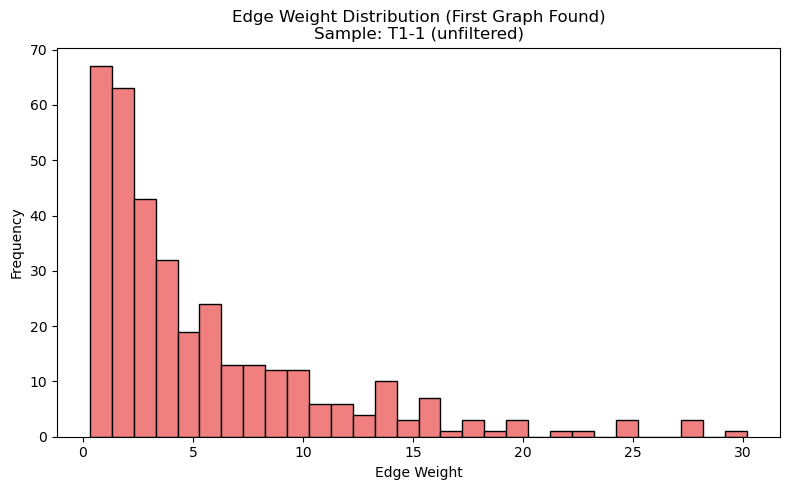

     Plot displayed above.

--- Processing Sample: T1-10 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 120
     Edges: 7140
     'relab' node attribute found: True

--- Processing Sample: T1-2 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 82
     Edges: 3321
     'relab' node attribute found: True

--- Processing Sample: T1-3 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 108
     Edges: 5778
     'relab' node attribute found: True

--- Processing Sample: T1-4 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 5
     Edges: 10
     'relab' node attribute found: True

--- Processing Sample: T1-5 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 76
     Edges: 2850
     'relab' node attribute found: True

--- Processing Sample: T1-6 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 59
     Edges: 1711
     'relab' node attribute found: True

--- Processing Sample: T1-7 ---
  -> Analyzing 'unfiltered' graph...
     Nodes: 23
     Edges: 253
     'relab' node at

In [4]:
# Paste all of this into one Jupyter Notebook cell

import os
import pickle
import networkx as nx
import time
import warnings
import matplotlib.pyplot as plt # Added for plotting
import numpy as np             # Added for numerical operations

# Optional: Suppress warnings if needed
# warnings.filterwarnings("ignore", category=UserWarning)

def analyze_and_plot_first_graph(individual_graphs_dir):
    """
    Simplified analysis: Prints counts/relab check for all graphs,
    but PLOTS edge weight distribution ONLY for the FIRST graph loaded successfully.

    Args:
        individual_graphs_dir (str): Path to the directory containing the
                                     individual sample subdirectories.
    """
    print("="*50)
    print(f"Starting Analysis in: {individual_graphs_dir}")
    print("(Will plot edge weight distribution for the first graph found)")
    print("="*50)
    start_run_time = time.time()

    # Validate input directory
    if not os.path.isdir(individual_graphs_dir):
        print(f"ERROR: Input directory not found: {individual_graphs_dir}")
        return

    sample_dirs_found = 0
    graphs_analyzed = 0
    load_errors = 0
    first_graph_plotted = False # Flag to plot only once

    # Iterate through items (potential sample directories)
    try:
        # Sort to ensure consistent "first" graph if directory listing order varies
        all_items = sorted(os.listdir(individual_graphs_dir))
    except Exception as e:
        print(f"ERROR listing directory contents: {e}")
        return

    print(f"Found {len(all_items)} items. Checking for sample folders...")

    # --- Loop through samples ---
    for item_name in all_items:
        # If we have already plotted, no need to check further samples for plotting
        # We still continue to print stats for other graphs if needed.
        # To stop entirely after plotting, uncomment the break statement at the end of the outer loop.

        item_path = os.path.join(individual_graphs_dir, item_name)

        # Process only if it's a directory
        if os.path.isdir(item_path):
            sample_id = item_name
            sample_dirs_found += 1
            print(f"\n--- Processing Sample: {sample_id} ---")

            files_to_check = {
                "unfiltered": os.path.join(item_path, "graph_unfiltered.pkl"),
                "filtered": os.path.join(item_path, "graph_filtered.pkl")
            }

            # --- Loop through graph types (unfiltered/filtered) ---
            for graph_type, pickle_path in files_to_check.items():
                if os.path.exists(pickle_path):
                    print(f"  -> Analyzing '{graph_type}' graph...")
                    try:
                        # Load graph from pickle file
                        with open(pickle_path, 'rb') as f:
                            G = pickle.load(f)

                        if not isinstance(G, nx.Graph):
                             print(f"  ERROR: File content is not a NetworkX Graph object: {pickle_path}")
                             load_errors += 1
                             continue # Skip to next file

                        graphs_analyzed += 1

                        # --- Basic Analysis (for ALL graphs) ---
                        num_nodes = G.number_of_nodes()
                        num_edges = G.number_of_edges()

                        relab_found = False
                        if num_nodes > 0:
                            for _, node_data in G.nodes(data=True):
                                if 'relab' in node_data:
                                    relab_found = True
                                    break

                        print(f"     Nodes: {num_nodes}")
                        print(f"     Edges: {num_edges}")
                        print(f"     'relab' node attribute found: {relab_found}")

                        # --- Plotting (ONLY for the FIRST graph successfully loaded) ---
                        if not first_graph_plotted:
                            print(f"     Attempting to plot edge weights for this graph (as it's the first)...")
                            if num_edges > 0:
                                # Extract finite edge weights safely
                                edge_weights = []
                                weight_key_found = False
                                for u, v, data in G.edges(data=True):
                                     if 'weight' in data:
                                         weight_key_found = True # Confirm the key exists at least once
                                         weight_val = data['weight']
                                         # Check if it's a number and finite
                                         if isinstance(weight_val, (int, float, np.number)) and np.isfinite(weight_val):
                                             edge_weights.append(weight_val)

                                if not weight_key_found:
                                     print("     'weight' attribute key not found on any edges. Cannot plot.")
                                elif not edge_weights:
                                    print("     Found 'weight' attribute, but no valid finite weights to plot.")
                                else:
                                    # Create the plot
                                    try:
                                        print(f"     Plotting distribution of {len(edge_weights)} edge weights...")
                                        plt.figure(figsize=(8, 5))
                                        plt.hist(edge_weights, bins=30, color='lightcoral', edgecolor='black')
                                        plt.title(f'Edge Weight Distribution (First Graph Found)\nSample: {sample_id} ({graph_type})')
                                        plt.xlabel('Edge Weight')
                                        plt.ylabel('Frequency')
                                        plt.tight_layout()
                                        plt.show() # Display the plot inline in Jupyter
                                        print(f"     Plot displayed above.")
                                        first_graph_plotted = True # Set flag so we don't plot again
                                    except Exception as plot_e:
                                        print(f"     ERROR during plotting: {plot_e}")
                                        # Still set flag to true to avoid repeated errors if plotting fails consistently
                                        first_graph_plotted = True
                            else:
                                 print("     Graph has no edges, cannot plot weights.")
                                 # Mark plotting as "done" for the first graph attempt, even if empty
                                 first_graph_plotted = True

                    # Handle errors during file loading or processing
                    except Exception as e:
                        load_errors += 1
                        print(f"  ERROR loading or processing {pickle_path}: {e}")

                # If we've already plotted, we can break this inner loop to move to the next sample faster
                if first_graph_plotted:
                   break # Stop checking filtered if unfiltered was plotted in this sample dir

        # If we only wanted to analyze until the first plot was done, uncomment the next lines
        # if first_graph_plotted:
        #    print("\nFirst graph plotted. Stopping analysis of further samples.")
        #    break

    # --- Summary ---
    end_run_time = time.time()
    print("\n" + "="*50)
    if sample_dirs_found == 0:
         print("Analysis Finished: No sample subdirectories found.")
    else:
        print(f"Analysis Finished: Checked {sample_dirs_found} sample directories.")
        print(f"  Loaded and analyzed basic info for: {graphs_analyzed} graphs.")
        if load_errors > 0:
             print(f"  Encountered errors loading/processing: {load_errors} graphs.")
        if not first_graph_plotted and graphs_analyzed > 0 :
             print("  NOTE: No edge weight plot generated (first graph had no edges/weights or failed plotting).")
        elif not first_graph_plotted and graphs_analyzed == 0:
             print("  NOTE: No graphs were successfully loaded to generate a plot from.")

    print(f"Total execution time: {end_run_time - start_run_time:.2f} seconds")
    print("="*50)


# --- !!! SET THIS PATH !!! ---
# Replace with the actual path to the directory holding all the sample folders
graphs_dir = "graph_outputs_combined_final/individual_graphs" # <-- EXAMPLE PATH, CHANGE THIS
# ---------------------------

# Run the analysis function
analyze_and_plot_first_graph(graphs_dir)

In [7]:
# -----------------------------------------------------------------------------
# Imports
# -----------------------------------------------------------------------------
import os
import pickle
import time
import traceback
import warnings
from collections import defaultdict
import random # Used in one version of bootstrapping logic provided

import pandas as pd
import numpy as np
import networkx as nx

# --- Plotting (optional, used by some analysis functions) ---
import matplotlib.pyplot as plt

# --- User-provided Logic Dependencies ---
from sklearn.preprocessing import normalize # For compute_all_weights
from scipy import stats                   # For filtering_pvals_for_each_sample
from joblib import Parallel, delayed      # For create_bootstrap_population

# --- Progress Bar (optional but recommended) ---
try:
    from tqdm.auto import tqdm
except ImportError:
    print("Optional dependency 'tqdm' not found. Progress bars will be disabled.")
    # Define a dummy tqdm if not installed
    def tqdm(iterable, *args, **kwargs):
        return iterable

# Optional: Suppress specific warnings if they become noisy
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning) # e.g., from divide by zero in numpy

# -----------------------------------------------------------------------------
# Data Processing Function (from earlier iterations)
# -----------------------------------------------------------------------------
def process_data(otu_file_path, metadata_file_path, distance_matrix_file_path=None,
                 sample_id='Sample', condition_id='Study.Group', phylo=False):

    """Processes OTU table, metadata, and optionally a phylogenetic (or otherwise) distance matrix."""

    print(f" Reading OTU table: {otu_file_path}")
    print(f" Reading metadata: {metadata_file_path}")

    # Determine separators
    sep_otu = '\t' if otu_file_path.lower().endswith('.tsv') else ','
    sep_meta = '\t' if metadata_file_path.lower().endswith('.tsv') else ','

    # Read files
    try:
        otu_table = pd.read_csv(otu_file_path, index_col=0, sep=sep_otu)
        print(f"  OTU table shape: {otu_table.shape}")
        metadata = pd.read_csv(metadata_file_path, sep=sep_meta)
        print(f"  Metadata shape before processing: {metadata.shape}")
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Error reading input files: {e}. Please check paths.")
    except Exception as e:
        raise ValueError(f"Error parsing input files: {e}")

    # --- Metadata Column Checks ---
    original_metadata_cols = metadata.columns.tolist()
    print(f"  Metadata columns: {original_metadata_cols}")

    if sample_id not in metadata.columns:
        print(f"  Warning: Sample ID column '{sample_id}' not found directly. Checking if it's the index...")
        metadata_reset = metadata.reset_index()
        if 'index' in metadata_reset.columns and sample_id == 'index':
             print(f"  Found sample ID '{sample_id}' as index.")
             metadata = metadata_reset
        elif sample_id in metadata_reset.columns:
            print(f"  Found sample ID '{sample_id}' after resetting index.")
            metadata = metadata_reset
        else:
             original_metadata_cols_str = ", ".join(original_metadata_cols)
             metadata_reset_cols_str = ", ".join(metadata_reset.columns.tolist())
             raise ValueError(f"Sample ID column '{sample_id}' not found in metadata. Original columns: [{original_metadata_cols_str}]. Columns after reset: [{metadata_reset_cols_str}]")

    if condition_id not in metadata.columns:
        metadata_cols_str = ", ".join(metadata.columns.tolist())
        raise ValueError(f"Condition ID column '{condition_id}' not found in metadata. Available columns: [{metadata_cols_str}]")

    # --- Sample ID Handling ---
    print(f"  Using Sample ID column: '{sample_id}'")
    print(f"  Using Condition ID column: '{condition_id}'")

    if not metadata[sample_id].is_unique:
        num_duplicates = metadata[sample_id].duplicated().sum()
        print(f"  Warning: Sample ID column '{sample_id}' contains {num_duplicates} duplicate values. Keeping first occurrence of each.")
        metadata = metadata.drop_duplicates(subset=[sample_id], keep='first')
        print(f"  Metadata shape after dropping duplicates: {metadata.shape}")

    try:
        metadata.set_index(sample_id, inplace=True)
    except KeyError:
         raise ValueError(f"Failed to set index using Sample ID column '{sample_id}'. Column might be missing despite checks.")

    # --- Align OTU Table and Metadata ---
    otu_table.index = otu_table.index.astype(str)
    metadata.index = metadata.index.astype(str)
    print(f"  OTU table samples: {otu_table.shape[0]}, OTUs: {otu_table.shape[1]}")
    print(f"  Metadata samples: {metadata.shape[0]}")

    common_samples = otu_table.index.intersection(metadata.index)
    print(f"  Found {len(common_samples)} common samples between OTU table and metadata.")

    if len(common_samples) == 0:
        otu_samples_head = otu_table.index[:5].tolist()
        meta_samples_head = metadata.index[:5].tolist()
        raise ValueError(f"No common samples found. Check Sample ID matching and formatting.\n"
                         f"  First 5 OTU index values: {otu_samples_head}\n"
                         f"  First 5 Metadata index values: {meta_samples_head}")

    otu_table = otu_table.loc[common_samples]
    metadata = metadata.loc[common_samples]
    print(f"  Aligned feature table shape: {otu_table.shape}")
    print(f"  Aligned metadata shape: {metadata.shape}")

    # --- OTU Table Processing ---
    try:
        otu_table = otu_table.astype(float)
    except ValueError as e:
        non_numeric_cols = otu_table.apply(lambda s: pd.to_numeric(s, errors='coerce').isna().any())
        problem_cols = non_numeric_cols[non_numeric_cols].index.tolist()
        raise ValueError(f"OTU table contains non-numeric values. Problematic columns might include: {problem_cols}. Original error: {e}")

    initial_otus = otu_table.shape[1]
    otu_table = otu_table.loc[:, (otu_table > 0).any(axis=0)] # Keep columns with at least one non-zero value
    otus_removed = initial_otus - otu_table.shape[1]
    if otus_removed > 0:
        print(f"  Removed {otus_removed} OTUs that were all zero across samples.")

    sample_sums = otu_table.sum(axis=1)
    zero_sum_samples = sample_sums[sample_sums <= 1e-9].index # Use small threshold for float comparison
    if not zero_sum_samples.empty:
        print(f"  Warning: Samples {zero_sum_samples.tolist()} have zero or near-zero total abundance. Removing these {len(zero_sum_samples)} samples before normalization.")
        otu_table = otu_table.drop(index=zero_sum_samples)
        metadata = metadata.drop(index=zero_sum_samples)
        sample_sums = sample_sums.drop(index=zero_sum_samples)

    if otu_table.empty:
        raise ValueError("OTU table is empty after filtering zero-sum samples. Cannot proceed.")

    # Perform safe division for normalization
    otu_table = otu_table.div(sample_sums, axis=0)
    otu_table = otu_table.fillna(0) # Replace any NaNs from division (shouldn't happen with check above)
    print(f"  Normalized OTU table to relative abundances. Final shape: {otu_table.shape}")

    # --- Grouping (Optional for return) ---
    otu_table_grouped = None
    if condition_id in metadata.columns:
         try:
            otu_table_grouped = otu_table.groupby(metadata[condition_id]).mean()
         except Exception as group_e:
             print(f"  Warning: Could not group OTU table by condition '{condition_id}': {group_e}")

    # --- Phylogenetic Distances (Optional) ---
    phylo_distances = None
    if phylo and distance_matrix_file_path:
        # (Phylo distance logic omitted for brevity, same as previous versions)
        pass

    print(" Data processing function finished.")
    # Return only necessary items for subsequent steps documented here
    return otu_table, metadata

# -----------------------------------------------------------------------------
# Functions Provided by User (Bootstrap P-Value Filtering Logic)
# -----------------------------------------------------------------------------

# Compute sample weights for each sample
def compute_sample_weights(sample_rel_otu):
    """Calculates pairwise weights within a single sample based on relative abundance."""
    # Ensure input is numpy array
    sample_rel_otu = np.asarray(sample_rel_otu)
    n_species = len(sample_rel_otu)

    # Handle edge cases
    if n_species < 2:
        return np.zeros((n_species, n_species)), np.zeros((n_species, n_species))

    binary_sample = (sample_rel_otu > 1e-9).astype(int) # Use threshold for float
    sample_binary_matrix = np.outer(binary_sample, binary_sample) # Co-occurrence within sample
    sample_matrix = np.tile(sample_rel_otu, (n_species, 1))

    original_array = np.diag(sample_matrix)
    # Use a small epsilon to prevent division by zero in edge cases
    original_array_safe = original_array + np.finfo(float).eps
    non_zero_mask = original_array > 1e-9

    inverted_non_zero_elements = np.zeros_like(original_array, dtype=float)
    inverted_non_zero_elements = np.divide(1.0, original_array_safe, where=non_zero_mask, out=inverted_non_zero_elements)
    inv_diag = np.diag(inverted_non_zero_elements)

    ratios = np.matmul(inv_diag, sample_matrix) # R = D^-1 * A

    # Calculate weights W_ij based on reciprocal of ratios
    weights = np.zeros_like(ratios)
    non_diagonal_mask = ~np.eye(n_species, dtype=bool)
    # Add epsilon to ratios denominator for safe division
    ratios_safe = ratios + np.finfo(float).eps
    valid_ratios_mask = (np.abs(ratios) > 1e-9) & non_diagonal_mask # Check if ratio is non-zero

    weights = np.divide(2.0, ratios_safe, where=valid_ratios_mask, out=weights)

    # Symmetrize using upper triangle
    weights_new = np.triu(weights, k=1)
    weights_new = weights_new + weights_new.T
    weights_new[~np.isfinite(weights_new)] = 0 # Handle potential infinities/NaNs

    return weights_new, sample_binary_matrix

# Compute weights for all samples (Averaging logic)
def compute_all_weights(raw_data):
    """Computes an average weight matrix across a set of samples."""
    raw_data = np.asarray(raw_data)
    if raw_data.ndim != 2 or raw_data.shape[0] == 0 or raw_data.shape[1] == 0:
         print("Warning: compute_all_weights received empty or invalid data.")
         if raw_data.ndim == 2 and raw_data.shape[1] > 0:
             num_species = raw_data.shape[1]
             return np.zeros((num_species, num_species)), np.zeros((num_species, num_species))
         else:
             raise ValueError("Cannot determine shape for empty/invalid input to compute_all_weights")

    # Normalize rows (samples) to relative abundance (L1 norm)
    relative_raw = normalize(raw_data, axis=1, norm='l1')
    num_samples, num_species = relative_raw.shape

    combined_weights = np.zeros((num_species, num_species))
    cooc_matrix = np.zeros((num_species, num_species)) # Sum of co-occurrences

    for i in range(num_samples):
        sample = relative_raw[i, :]
        # Skip if sample has no valid data after normalization
        if np.sum(sample) < 1e-9:
            continue
        w, cooc = compute_sample_weights(sample)
        # Add only if shapes match (can happen if compute_sample_weights returns zeros)
        if w.shape == combined_weights.shape:
             combined_weights += w
             cooc_matrix += cooc
        else:
            print(f"Warning: Shape mismatch in compute_all_weights for sample {i}. Skipping.")


    # Average weights: Divide sum of weights by number of times species co-occurred
    final_matrix = np.divide(combined_weights, cooc_matrix, where=cooc_matrix!=0, out=np.zeros_like(combined_weights))
    final_matrix[~np.isfinite(final_matrix)] = 0 # Handle potential NaNs/Infs

    return final_matrix, cooc_matrix

# Create bootstrap population and calculate average weight matrices
def create_bootstrap_population(observed_data_df, # Takes DataFrame for condition
                                n=100,
                                condition_group="Control", # For output naming
                                output_dir="bootstrap_analysis"):
    """Generates bootstrap weight matrices for a given condition's data."""
    print(f"Bootstrapping {n} replicates for condition: {condition_group}")
    directory = os.path.join(output_dir, f"bstrap_results_{condition_group}")
    matrices_dir = os.path.join(directory, "matrices")
    os.makedirs(matrices_dir, exist_ok=True)
    print(f" Bootstrap matrices will be saved in: {matrices_dir}")

    raw_data = observed_data_df.to_numpy()
    n_samples, num_species = raw_data.shape
    if n_samples == 0:
        print(" ERROR: No data provided for bootstrapping.")
        return None

    # Create list of bootstrap datasets (resampling rows indices)
    bootstrap_indices_list = [np.random.choice(n_samples, size=n_samples, replace=True) for _ in range(n)]
    # Generate datasets based on indices
    bstrap_otus_datasets = [raw_data[indices] for indices in bootstrap_indices_list]

    # Function to process a single bootstrap replicate
    def process_bootstrap_sample(b, otu_sample):
        try:
            # Compute the *average* weight matrix for this bootstrap replicate
            w, _ = compute_all_weights(otu_sample)
            # Save the matrix for this replicate
            np.savetxt(os.path.join(matrices_dir, f"bstrap_weight_matrix_{b}.csv"), w, delimiter=",")
            return w # Return the matrix
        except Exception as e:
            print(f" Error processing bootstrap replicate {b}: {e}")
            # Return matrix of zeros on error, with correct shape
            return np.zeros((num_species, num_species))

    # Run bootstrap processing in parallel
    print(f" Running {n} replicates in parallel (using joblib)...")
    results_matrices = Parallel(n_jobs=-1)(delayed(process_bootstrap_sample)(b, otu) for b, otu in enumerate(bstrap_otus_datasets))

    # Filter out potential error results (e.g., None or incorrect shapes if added)
    valid_results_matrices = [m for m in results_matrices if isinstance(m, np.ndarray) and m.shape == (num_species, num_species)]

    if not valid_results_matrices or len(valid_results_matrices) < n * 0.5: # Check if at least half succeeded
        print(f" ERROR: Failed to generate sufficient valid bootstrap matrices ({len(valid_results_matrices)}/{n}). Check errors above.")
        return None

    # Calculate element-wise mean and std deviation across bootstrap matrices
    print(" Calculating mean and std deviation across bootstrap matrices...")
    try:
        stacked_matrices = np.stack(valid_results_matrices, axis=0)
        bstrap_means = np.mean(stacked_matrices, axis=0)
        bstrap_stds = np.std(stacked_matrices, axis=0)

        np.savetxt(os.path.join(directory, f"_means_{condition_group}.csv"), bstrap_means, delimiter=",")
        np.savetxt(os.path.join(directory, f"_stds_{condition_group}.csv"), bstrap_stds, delimiter=",")
        print(f" Saved mean and std matrices to: {directory}")
        return directory # Return path to results for filtering step
    except Exception as e:
        print(f" ERROR calculating/saving mean/std matrices: {e}")
        return None

# --- MODIFIED Function to Filter Samples and Delete Matrices ---

def filtering_pvals_for_each_sample(df_cond, # Feature table for condition
                                    condition_group, # Name for output
                                    bstrap_results_dir, # Directory with bootstrap matrices
                                    thresh=0.05, # p-value threshold
                                    output_dir="bootstrap_analysis", # Base output directory
                                    delete_bootstrap_matrices=True): # Flag to control deletion
    """
    Filters each sample's graph based on comparison to bootstrap distributions
    and optionally deletes the individual bootstrap matrix files after use.
    """
    print(f"\nFiltering individual samples for condition: {condition_group} (p < {thresh})")
    matrices_dir = os.path.join(bstrap_results_dir, "matrices") # Path to saved bootstrap matrices
    unfiltered_matrices_dir = os.path.join(output_dir, "per_sample_unfiltered_matrices", condition_group)
    os.makedirs(unfiltered_matrices_dir, exist_ok=True)
    filtered_matrices_dir = os.path.join(output_dir, "per_sample_filtered_matrices", condition_group)
    os.makedirs(filtered_matrices_dir, exist_ok=True)
    filtered_graphs_dir = os.path.join(output_dir, "per_sample_filtered_graphs", condition_group)
    os.makedirs(filtered_graphs_dir, exist_ok=True)
    # (Optional: print output directories)
    # print(f" Unfiltered sample matrices will be saved in: {unfiltered_matrices_dir}")
    # print(f" Filtered sample matrices will be saved in: {filtered_matrices_dir}")
    # print(f" Filtered sample graphs will be saved in: {filtered_graphs_dir}")


    # Load bootstrap results (individual weight matrices)
    bs_data_3d = None # Initialize
    try:
        bootstrap_files = [f for f in os.listdir(matrices_dir) if f.startswith('bstrap_weight_matrix_') and f.endswith('.csv')]
        if not bootstrap_files:
            print(f" ERROR: No bootstrap matrix files found in {matrices_dir}")
            return None, None # Indicate failure
        # Load all matrices into a list
        bootstrap_matrices = [np.loadtxt(os.path.join(matrices_dir, f), delimiter=",") for f in bootstrap_files]
        # Filter potentially corrupted files
        bootstrap_matrices = [m for m in bootstrap_matrices if isinstance(m, np.ndarray) and m.ndim == 2]
        if not bootstrap_matrices:
             print(f" ERROR: Could not load any valid bootstrap matrices from {matrices_dir}")
             return None, None
        bs_data_3d = np.stack(bootstrap_matrices, axis=0)
        print(f" Loaded {bs_data_3d.shape[0]} bootstrap matrices into memory.")

        # <<< --- ADDED: Delete individual bootstrap matrix files --- >>>
        if delete_bootstrap_matrices:
            print(f"  Attempting to delete individual bootstrap matrix files from {matrices_dir}...")
            deletion_errors = 0
            files_deleted_count = 0
            try:
                # Use the list of files we already identified
                for f in bootstrap_files:
                    file_path = os.path.join(matrices_dir, f)
                    try:
                        if os.path.exists(file_path): # Check if it still exists
                            os.remove(file_path)
                            files_deleted_count += 1
                    except OSError as delete_e: # Catch specific OS errors like permission denied
                        print(f"    Warning: Could not delete file {f}: {delete_e}")
                        deletion_errors += 1
                if deletion_errors == 0:
                    print(f"  Successfully deleted {files_deleted_count} bootstrap matrix files.")
                else:
                    print(f"  Finished deletion attempt: {files_deleted_count} deleted, {deletion_errors} errors.")
            except Exception as list_delete_e:
                # Catch errors during listing/path joining if files were somehow modified
                print(f"  ERROR during deletion of bootstrap matrices: {list_delete_e}")
        else:
             print("  Skipping deletion of individual bootstrap matrix files (delete_bootstrap_matrices=False).")
        # <<< --- END OF DELETION CODE --- >>>

    except FileNotFoundError:
         print(f" ERROR: Bootstrap matrices directory not found: {matrices_dir}")
         return None, None
    except Exception as e:
        print(f" ERROR loading bootstrap matrices: {e}")
        # If loading fails, bs_data_3d will be None, handled below
        return None, None

    # Check if loading succeeded before proceeding
    if bs_data_3d is None:
         print(f" Cannot proceed with filtering for {condition_group} due to bootstrap loading errors.")
         return None, None

    # Get original data for the condition as numpy array
    data_cond = df_cond.to_numpy()
    num_samples, num_species = data_cond.shape
    species_names = df_cond.columns # Get species names

    # Store bootstrap weights distribution for each edge (i, j)
    bs_weight_distributions = defaultdict(list)
    num_replicates = bs_data_3d.shape[0] # Use actual loaded count
    # Populate the dictionary from the 3D array
    for i in range(num_species):
        for j in range(i + 1, num_species):
            # Check if indices are within bounds of loaded data
            if i < bs_data_3d.shape[1] and j < bs_data_3d.shape[2]:
                 weights_for_edge = bs_data_3d[:, i, j]
                 # Store only finite weights
                 bs_weight_distributions[i, j] = weights_for_edge[np.isfinite(weights_for_edge)].tolist()


    # --- Process each original sample in the condition ---
    print(f" Processing {num_samples} samples in condition {condition_group}...")
    filtering_summary_info = {} # Dictionary to store filtering summary per sample
    filtered_otu_table_data = df_cond.copy() # Start with original relative abundances

    sample_iterator = tqdm(range(num_samples), desc=" Filtering Samples", leave=False, ncols=100) if 'tqdm' in globals() else range(num_samples)

    for counter in sample_iterator:
        sample_data_rel = data_cond[counter, :] # Get relative abundances for sample
        sample_name = df_cond.index[counter] # Get sample ID
        safe_sample_name = str(sample_name).replace('/', '-').replace('\\', '-').replace(':', '-').replace(' ', '_') # Sanitize

        # --- Calculate weights for the individual sample ---
        sample_weights, _ = compute_sample_weights(sample_data_rel)

        # Save unfiltered weights
        unfiltered_matrix_path = os.path.join(unfiltered_matrices_dir, f"unfiltered_weights_{safe_sample_name}.csv")
        np.savetxt(unfiltered_matrix_path, sample_weights, delimiter=",")

        # --- Filter edges based on t-test against bootstrap distribution ---
        filtered_sample_weights = sample_weights.copy() # Start with unfiltered weights
        total_edges_in_sample = 0
        edges_filtered_count = 0

        for i in range(num_species):
            for j in range(i + 1, num_species):
                sample_w_ij = sample_weights[i, j]
                # Consider only edges present (non-zero, finite) in the original sample's graph
                if sample_w_ij != 0 and np.isfinite(sample_w_ij):
                    total_edges_in_sample += 1

                    # Get bootstrap distribution for this edge
                    if (i, j) in bs_weight_distributions:
                        bs_dist = bs_weight_distributions[i, j]
                        # Perform t-test only if bootstrap distribution has variance
                        if len(bs_dist) > 1 and np.std(bs_dist) > 1e-9: # Avoid division by zero / float issues
                            with warnings.catch_warnings(): # Suppress potential warnings
                                warnings.simplefilter("ignore", category=RuntimeWarning)
                                try:
                                    t_stat, p_val = stats.ttest_1samp(
                                        a=bs_dist,
                                        popmean=sample_w_ij,
                                        alternative='two-sided',
                                        nan_policy='omit'
                                    )
                                     # Filter if p-value is BELOW threshold (significantly different)
                                    if p_val < thresh:
                                        filtered_sample_weights[i, j] = filtered_sample_weights[j, i] = 0
                                        edges_filtered_count += 1
                                except ValueError as ttest_e:
                                     # Handle cases where t-test fails unexpectedly (e.g., all values equal popmean)
                                     # print(f"  T-test warning for edge ({i},{j}) in sample {sample_name}: {ttest_e}. Keeping edge.")
                                     pass # Keep the edge if test fails


        # --- Save filtered results and collect summary ---
        filtering_summary_info[sample_name] = {
            "nodes_in": np.count_nonzero(sample_data_rel > 1e-9),
            "edges_in": total_edges_in_sample,
            "edges_filtered_out": edges_filtered_count,
            "prop_filtered": (edges_filtered_count / total_edges_in_sample if total_edges_in_sample > 0 else 0)
        }

        filtered_matrix_path = os.path.join(filtered_matrices_dir, f"filtered_weights_{safe_sample_name}.csv")
        np.savetxt(filtered_matrix_path, filtered_sample_weights, delimiter=",")

        # --- Create and Save Filtered Graph ---
        G_filtered = nx.Graph()
        present_species_indices = np.where(sample_data_rel > 1e-9)[0]
        nodes_added_to_graph = set()
        for idx in present_species_indices:
             node_name = species_names[idx]
             relab = sample_data_rel[idx]
             G_filtered.add_node(node_name, relab=relab)
             nodes_added_to_graph.add(node_name)

        for i in range(num_species):
            for j in range(i + 1, num_species):
                if filtered_sample_weights[i, j] != 0:
                    node_i = species_names[i]; node_j = species_names[j]
                    if node_i in nodes_added_to_graph and node_j in nodes_added_to_graph:
                        G_filtered.add_edge(node_i, node_j, weight=filtered_sample_weights[i, j])

        filtering_summary_info[sample_name]["nodes_out"] = G_filtered.number_of_nodes()
        filtered_graph_path = os.path.join(filtered_graphs_dir, f"filtered_graph_{safe_sample_name}.graphml")
        try:
            nx.write_graphml(G_filtered, filtered_graph_path)
        except Exception as graph_e:
             print(f"  ERROR saving filtered graph for sample {sample_name}: {graph_e}")

        # --- Update the filtered OTU table ---
        remaining_nodes = list(G_filtered.nodes())
        cols_to_zero_out = df_cond.columns[~df_cond.columns.isin(remaining_nodes)]
        filtered_otu_table_data.loc[sample_name, cols_to_zero_out] = 0

    # --- Save summary and filtered OTU table for the condition ---
    print(f"\nSaving summary and filtered OTU table for condition: {condition_group}")
    summary_df = pd.DataFrame.from_dict(filtering_summary_info, orient="index")
    summary_csv_path = os.path.join(output_dir, f"filtering_summary_{condition_group}.csv")
    try: summary_df.to_csv(summary_csv_path); print(f" Saved filtering summary: {summary_csv_path}")
    except Exception as summary_e: print(f" ERROR saving filtering summary CSV: {summary_e}")

    filtered_otu_table_path = os.path.join(output_dir, f"filtered_otu_table_{condition_group}.csv")
    try: filtered_otu_table_data.to_csv(filtered_otu_table_path); print(f" Filtered OTU table saved: {filtered_otu_table_path}")
    except Exception as otu_e: print(f" ERROR saving filtered OTU table CSV: {otu_e}")

    return filtered_otu_table_data, summary_df

# -----------------------------------------------------------------------------
# Orchestrating Function for Bootstrap P-Value Filtering
# -----------------------------------------------------------------------------

def run_bootstrap_filtering_per_condition(feature_table,
                                          metadata,
                                          condition_id_col,
                                          output_dir,
                                          num_bootstraps=100,
                                          p_value_threshold=0.1,
                                          min_samples_bootstrap=5):
    """
    Orchestrates bootstrapping and p-value filtering for each condition.
    Uses the user-provided functions.
    """
    all_conditions = metadata[condition_id_col].unique()
    print(f"\n--- Starting Bootstrap P-Value Filtering Workflow ({len(all_conditions)} conditions) ---")
    print(f" Conditions based on: '{condition_id_col}'")
    print(f" Bootstraps per condition: {num_bootstraps}")
    print(f" P-value threshold for filtering: {p_value_threshold}")
    print(f" Min samples per condition: {min_samples_bootstrap}")

    # Base directory for all outputs of this specific workflow
    bootstrap_output_base_dir = os.path.join(output_dir, "bootstrap_pval_filtering")
    os.makedirs(bootstrap_output_base_dir, exist_ok=True)
    print(f" Outputs will be saved under: '{bootstrap_output_base_dir}'")

    all_filtered_otus = {}
    all_summaries = {}
    conditions_processed_count = 0
    conditions_skipped_count = 0

    condition_iterator = tqdm(all_conditions, desc="Processing Conditions (PVal Filter)", leave=True) if 'tqdm' in globals() else all_conditions

    for condition_group in condition_iterator:
        safe_condition_name = str(condition_group).replace(' ', '_').replace('/', '-').replace('\\', '-')
        print(f"\n{'='*10} Processing Condition: {condition_group} {'='*10}")

        condition_sample_ids = metadata[metadata[condition_id_col] == condition_group].index
        valid_condition_sample_ids = condition_sample_ids.intersection(feature_table.index)

        if len(valid_condition_sample_ids) < min_samples_bootstrap:
            print(f" Skipping condition '{condition_group}': Only {len(valid_condition_sample_ids)} valid samples found, need at least {min_samples_bootstrap}.")
            conditions_skipped_count += 1
            continue

        df_cond = feature_table.loc[valid_condition_sample_ids]
        print(f" Condition '{condition_group}' has {len(df_cond)} samples for analysis.")

        # 1. Run bootstrapping to generate reference weight distributions
        bstrap_results_dir = create_bootstrap_population(
            observed_data_df=df_cond,
            n=num_bootstraps,
            condition_group=safe_condition_name,
            output_dir=bootstrap_output_base_dir
        )

        if bstrap_results_dir is None:
             print(f" ERROR: Bootstrapping failed for condition '{condition_group}'. Skipping filtering.")
             conditions_skipped_count += 1
             continue

        # 2. Run filtering for each sample within the condition
        filtered_otu_table, summary_df = filtering_pvals_for_each_sample(
            df_cond=df_cond, # Pass the condition's feature table (relative abundances)
            condition_group=safe_condition_name,
            bstrap_results_dir=bstrap_results_dir,
            thresh=p_value_threshold,
            output_dir=bootstrap_output_base_dir
        )

        # Store results if successful
        if filtered_otu_table is not None:
             all_filtered_otus[condition_group] = filtered_otu_table
        if summary_df is not None:
             all_summaries[condition_group] = summary_df
        conditions_processed_count += 1


    print("\n" + "="*50)
    print("Bootstrap P-Value Filtering Workflow Finished.")
    print(f" Conditions processed: {conditions_processed_count}")
    print(f" Conditions skipped (due to sample size or errors): {conditions_skipped_count}")
    print("="*50)
    # Optionally return collected results for further use
    return all_filtered_otus, all_summaries


# -----------------------------------------------------------------------------
# Optional: Functions for other graph types (Individual, Aggregated Condition)
# (Copied from previous versions for completeness, can be gated by flags)
# -----------------------------------------------------------------------------

# --- Function to create graph for a single sample ---
def create_individual_sample_graph(sample_data_series, threshold=None):
    """Creates a NetworkX graph for a single sample's abundance data."""
    G = nx.Graph()
    numeric_sample_data = pd.to_numeric(sample_data_series, errors='coerce').fillna(0)
    nonzero_species = numeric_sample_data[numeric_sample_data > 1e-9] # Use threshold

    if nonzero_species.empty: return G
    elif len(nonzero_species) == 1:
        species, abundance = nonzero_species.index[0], nonzero_species.iloc[0]
        G.add_node(species, relab=abundance)
        return G

    for species, abundance in nonzero_species.items(): G.add_node(species, relab=abundance)

    species_list = nonzero_species.index.tolist()
    abundances_array = nonzero_species.to_numpy()
    weights_matrix, _ = compute_sample_weights(abundances_array)

    for i in range(len(species_list)):
        for j in range(i + 1, len(species_list)):
            weight = weights_matrix[i, j]
            if np.isfinite(weight) and weight != 0: # Check non-zero finite weight
                if threshold is None or threshold <= 0: # Unfiltered
                    G.add_edge(species_list[i], species_list[j], weight=weight)
                elif abs(weight) > threshold: # Filtered
                    G.add_edge(species_list[i], species_list[j], weight=weight)
    return G

# --- Function to loop through samples and save individual graphs ---
def create_and_save_individual_graphs(feature_table, base_output_dir, edge_threshold):
    """Creates and saves filtered and unfiltered graphs for each individual sample."""
    print(f"\n--- Starting Simple INDIVIDUAL Sample Graph Generation ---")
    individual_dir = os.path.join(base_output_dir, "individual_graphs_simple") # Changed dir name
    os.makedirs(individual_dir, exist_ok=True)
    print(f" Individual graphs will be saved in: '{individual_dir}'")
    num_samples = len(feature_table)
    start_time = time.time()
    samples_processed = 0
    errors_encountered = 0

    sample_iterator = tqdm(feature_table.iterrows(), total=num_samples, desc=" Individual Graphs", leave=False, ncols=100) if 'tqdm' in globals() else feature_table.iterrows()

    for i, (sample_id, sample_data) in enumerate(sample_iterator):
        safe_sample_id = str(sample_id).replace('/', '-').replace('\\', '-').replace(':', '-').replace(' ', '_')
        sample_output_dir = os.path.join(individual_dir, safe_sample_id)
        os.makedirs(sample_output_dir, exist_ok=True)
        try:
            G_unfiltered = create_individual_sample_graph(sample_data, threshold=None)
            if G_unfiltered.number_of_nodes() > 0:
                unfiltered_path = os.path.join(sample_output_dir, "graph_unfiltered.pkl")
                with open(unfiltered_path, 'wb') as f: pickle.dump(G_unfiltered, f)

            G_filtered = create_individual_sample_graph(sample_data, threshold=edge_threshold)
            if G_filtered.number_of_edges() > 0:
                 filtered_path = os.path.join(sample_output_dir, "graph_filtered.pkl")
                 with open(filtered_path, 'wb') as f: pickle.dump(G_filtered, f)
            samples_processed += 1
        except Exception as e:
            errors_encountered += 1
            print(f"\n ERROR processing individual graph for sample {sample_id}: {e}")

    end_time = time.time()
    print(f"--- Finished Simple INDIVIDUAL Sample Graph Generation ({end_time - start_time:.2f}s) ---")
    print(f"  Samples processed: {samples_processed}, Errors: {errors_encountered}")

# --- Functions for Simple Aggregated Condition Graphs ---
def aggregate_samples_for_condition(feature_table, metadata, condition_group, condition_id_col):
    """Aggregate samples by averaging for each condition."""
    samples_in_condition = metadata[metadata[condition_id_col] == condition_group].index
    valid_samples = samples_in_condition.intersection(feature_table.index)
    if valid_samples.empty: return pd.Series(dtype=float), pd.Index([])
    condition_feature_table = feature_table.loc[valid_samples]
    if condition_feature_table.empty: return pd.Series(dtype=float), valid_samples
    aggregated_feature_table = condition_feature_table.mean(axis=0).fillna(0)
    return aggregated_feature_table, valid_samples

def create_graph_from_aggregated_data(aggregated_data, threshold):
    """Create a graph based on aggregated data and edge weight threshold."""
    G = nx.Graph()
    nonzero_species = aggregated_data[aggregated_data > 1e-9]
    if nonzero_species.empty: return G
    elif len(nonzero_species) == 1:
        sp, ab = nonzero_species.index[0], nonzero_species.iloc[0]; G.add_node(sp, relab=ab); return G
    for species, abundance in nonzero_species.items(): G.add_node(species, relab=abundance)
    species_list = nonzero_species.index.tolist(); abundance_array = nonzero_species.to_numpy()
    weights_matrix, _ = compute_sample_weights(abundance_array)
    for i in range(len(species_list)):
        for j in range(i + 1, len(species_list)):
            weight = weights_matrix[i, j]
            if np.isfinite(weight) and abs(weight) > threshold:
                G.add_edge(species_list[i], species_list[j], weight=weight)
    return G

def filter_feature_table(feature_table, graph_nodes):
    """Filter feature table columns to include only graph nodes."""
    valid_nodes = [node for node in graph_nodes if node in feature_table.columns]
    if not valid_nodes: return pd.DataFrame(index=feature_table.index)
    return feature_table[valid_nodes]

def create_simple_condition_graphs(feature_table, metadata, output_dir, condition_id_col, edge_threshold):
    """Creates and saves simple AGGREGATED graphs for each condition."""
    print(f"\n--- Starting Simple AGGREGATED Condition Graph Generation ---")
    base_condition_dir = os.path.join(output_dir, "condition_graphs_aggregated")
    os.makedirs(base_condition_dir, exist_ok=True)
    print(f" Aggregated condition graphs will be saved in: '{base_condition_dir}'")
    conditions = metadata[condition_id_col].unique()
    cond_iterator = tqdm(conditions, desc="Aggregated Conditions", leave=False) if 'tqdm' in globals() else conditions
    for group in cond_iterator:
        safe_name = str(group).replace(' ', '_').replace('/', '-').replace('\\', '-')
        cond_out_dir = os.path.join(base_condition_dir, safe_name); os.makedirs(cond_out_dir, exist_ok=True)
        agg_data, samples = aggregate_samples_for_condition(feature_table, metadata, group, condition_id_col)
        if agg_data.empty: continue
        G_agg = create_graph_from_aggregated_data(agg_data, threshold=edge_threshold)
        if G_agg.number_of_nodes() == 0: continue
        try:
            pkl_path = os.path.join(cond_out_dir, f"graph_agg_{safe_name}.pkl")
            gml_path = os.path.join(cond_out_dir, f"graph_agg_{safe_name}.graphml")
            with open(pkl_path, 'wb') as f: pickle.dump(G_agg, f)
            nx.write_graphml(G_agg, gml_path)
        except Exception as e: print(f" Error saving aggregated graph for {group}: {e}")
        # Optional: Save filtered table based on this aggregated graph
        try:
            nodes = list(G_agg.nodes()); valid_samples = samples.intersection(feature_table.index)
            if not valid_samples.empty:
                ft_filt = filter_feature_table(feature_table.loc[valid_samples], nodes)
                if not ft_filt.empty:
                    ft_filt_path = os.path.join(cond_out_dir, f"ft_agg_filt_{safe_name}.csv")
                    ft_filt.to_csv(ft_filt_path)
        except Exception as e: print(f" Error saving filtered table for aggregated {group}: {e}")
    print(f"--- Finished Simple AGGREGATED Condition Graph Generation ---")

# -----------------------------------------------------------------------------
# Main Execution Block
# -----------------------------------------------------------------------------
if __name__ == "__main__":

    # --- Configuration ---
    print("--- Configuration Settings ---")
    # File paths (UPDATE THESE)
    otu_file_path = "/Users/nandini.gadhia/Documents/projects/gp_omics/data/toy_otu_table.csv"
    metadata_file_path = "/Users/nandini.gadhia/Documents/projects/gp_omics/data/toy_metadata.tsv"

    # Column names (UPDATE THESE)
    sample_id_col = 'Sample-ID'     # Column name for sample IDs in metadata
    condition_id_col = 'Group ID'   # Column name for the condition/group in metadata

    # Output directory (UPDATE IF NEEDED)
    output_dir = "microbiome_network_analysis_outputs" # Base directory for all outputs

    # --- Analysis Workflow Flags ---
    # Set these to True or False to enable/disable specific analyses
    run_simple_individual_graphs = False    # Generate basic filtered/unfiltered graphs per sample?
    run_simple_aggregated_graphs = False    # Generate graphs from simple condition averages?
    run_bootstrap_pval_filtering = True     # Run the user-provided bootstrap p-value filtering?

    # --- Parameters for Analyses ---
    # Edge weight threshold for SIMPLE filtered graphs (individual & aggregated)
    simple_graph_edge_threshold = 0.1

    # Parameters for Bootstrap P-Value Filtering
    num_bootstraps_pval = 100     # Number of bootstrap replicates
    pval_threshold = 0.05         # p-value cutoff for filtering sample edges
    min_samples_pval = 5          # Min samples per condition required for this workflow

    print(f"OTU Table Path: {otu_file_path}")
    print(f"Metadata Path: {metadata_file_path}")
    print(f"Sample ID Column: '{sample_id_col}'")
    print(f"Condition ID Column: '{condition_id_col}'")
    print(f"Base Output Directory: '{output_dir}'")
    print(f"\nWorkflow Selection:")
    print(f"  Run Simple Individual Graphs: {run_simple_individual_graphs} (Threshold: {simple_graph_edge_threshold})")
    print(f"  Run Simple Aggregated Condition Graphs: {run_simple_aggregated_graphs} (Threshold: {simple_graph_edge_threshold})")
    print(f"  Run Bootstrap P-Value Filtering: {run_bootstrap_pval_filtering} (Bootstraps: {num_bootstraps_pval}, P-Value: {pval_threshold}, Min Samples: {min_samples_pval})")
    print("-" * 30)

    # --- Start Workflow ---
    print("\n--- Starting Data Processing and Analysis Workflow ---")
    print(f"Script started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    overall_start_time = time.time()

    try:
        # Ensure base output directory exists
        os.makedirs(output_dir, exist_ok=True)
        print(f"\nOutput directory confirmed: '{os.path.abspath(output_dir)}'")

        # 1. Process Data
        print("\n[Step 1] Processing input data...")
        data_start_time = time.time()
        # Ensure process_data returns only feature_table and metadata if others aren't needed
        feature_table, metadata = process_data(
            otu_file_path, metadata_file_path,
            sample_id=sample_id_col,
            condition_id=condition_id_col
        )[:2] # Take only first two return values
        print(f"[Step 1] Data processed successfully ({time.time() - data_start_time:.2f}s).")
        print(f"  Final feature table dimensions (Samples x Species): {feature_table.shape}")
        print(f"  Final metadata dimensions (Samples x Attributes): {metadata.shape}")
        print("-"*50)

        # 2. Create and Save Simple Individual Sample Graphs (Optional)
        if run_simple_individual_graphs:
            print("\n[Step 2] Creating Simple Individual Sample Graphs...")
            create_and_save_individual_graphs(
                feature_table,
                output_dir,
                edge_threshold=simple_graph_edge_threshold
            )
            print("[Step 2] Simple individual graph generation finished.")
            print("-"*50)
        else:
             print("\n[Step 2] Creating Simple Individual Sample Graphs... SKIPPED")
             print("-"*50)


        # 3. Create and Save Simple Aggregated Condition-Level Graphs (Optional)
        if run_simple_aggregated_graphs:
            print("\n[Step 3] Creating Simple Aggregated Condition-Level Graphs...")
            create_simple_condition_graphs(
                feature_table,
                metadata,
                output_dir,
                condition_id_col=condition_id_col,
                edge_threshold=simple_graph_edge_threshold
            )
            print("[Step 3] Simple aggregated condition graph generation finished.")
            print("-"*50)
        else:
             print("\n[Step 3] Creating Simple Aggregated Condition-Level Graphs... SKIPPED")
             print("-"*50)


        # 4. Run Bootstrap P-Value Filtering (User-Provided Logic, Optional)
        if run_bootstrap_pval_filtering:
            print("\n[Step 4] Running Bootstrap P-Value Filtering Workflow...")
            pval_filter_start_time = time.time()
            # This function handles looping through conditions internally
            filtered_otu_tables_by_cond, filter_summaries_by_cond = run_bootstrap_filtering_per_condition(
                feature_table=feature_table, # Pass the main processed feature table
                metadata=metadata,
                condition_id_col=condition_id_col,
                output_dir=output_dir, # Base output directory
                num_bootstraps=num_bootstraps_pval,
                p_value_threshold=pval_threshold,
                min_samples_bootstrap=min_samples_pval
            )
            print(f"Bootstrap P-Value Filtering finished ({time.time() - pval_filter_start_time:.2f}s).")
            # Example: Access results if needed later in the script
            # if 'ConditionA' in filtered_otu_tables_by_cond:
            #     print("Filtered OTU table for ConditionA:", filtered_otu_tables_by_cond['ConditionA'].shape)
            print("-"*50)
        else:
             print("\n[Step 4] Bootstrap P-Value Filtering Workflow... SKIPPED")
             print("-"*50)


        # --- End Workflow ---
        overall_end_time = time.time()
        print("\n" + "="*50)
        print("--- All processing finished successfully ---")
        print(f"Total execution time: {overall_end_time - overall_start_time:.2f} seconds")
        print(f"Output saved in base directory: {os.path.abspath(output_dir)}")
        print("Check subdirectories for results from enabled analyses:")
        if run_simple_individual_graphs: print(" - individual_graphs_simple/")
        if run_simple_aggregated_graphs: print(" - condition_graphs_aggregated/")
        if run_bootstrap_pval_filtering: print(" - bootstrap_pval_filtering/")
        print("="*50)

    # --- Error Handling ---
    except FileNotFoundError as e:
        print(f"\n--- FATAL ERROR: Input file not found ---", flush=True)
        print(e); print("Please check paths in the Configuration section.", flush=True)
    except ValueError as ve:
        print(f"\n--- FATAL ERROR: Data validation or processing error ---", flush=True)
        print(ve); print("Check input file formats and column names.", flush=True)
    except KeyError as ke:
        print(f"\n--- FATAL ERROR: Column not found ---", flush=True)
        print(f"Column '{ke}' not found. Check `sample_id_col`/`condition_id_col` config.", flush=True)
    except MemoryError:
         print(f"\n--- FATAL ERROR: Insufficient memory ---", flush=True)
         print("Consider using a machine with more RAM or processing smaller datasets.", flush=True)
    except Exception as e:
        print(f"\n--- An unexpected FATAL error occurred ---", flush=True)
        traceback.print_exc() # Print detailed traceback

    finally:
        print(f"\nScript finished at: {time.strftime('%Y-%m-%d %H:%M:%S')}")

--- Configuration Settings ---
OTU Table Path: /Users/nandini.gadhia/Documents/projects/gp_omics/data/toy_otu_table.csv
Metadata Path: /Users/nandini.gadhia/Documents/projects/gp_omics/data/toy_metadata.tsv
Sample ID Column: 'Sample-ID'
Condition ID Column: 'Group ID'
Base Output Directory: 'microbiome_network_analysis_outputs'

Workflow Selection:
  Run Simple Individual Graphs: False (Threshold: 0.1)
  Run Simple Aggregated Condition Graphs: False (Threshold: 0.1)
  Run Bootstrap P-Value Filtering: True (Bootstraps: 100, P-Value: 0.05, Min Samples: 5)
------------------------------

--- Starting Data Processing and Analysis Workflow ---
Script started at: 2025-04-19 19:43:06

Output directory confirmed: '/Users/nandini.gadhia/Documents/projects/gp_omics/microbiome_network_analysis_outputs'

[Step 1] Processing input data...
 Reading OTU table: /Users/nandini.gadhia/Documents/projects/gp_omics/data/toy_otu_table.csv
 Reading metadata: /Users/nandini.gadhia/Documents/projects/gp_omics/

Processing Conditions (PVal Filter):   0%|          | 0/2 [00:00<?, ?it/s]


========== Processing Condition: Control ==========
 Condition 'Control' has 10 samples for analysis.
Bootstrapping 100 replicates for condition: Control
 Bootstrap matrices will be saved in: microbiome_network_analysis_outputs/bootstrap_pval_filtering/bstrap_results_Control/matrices
 Running 100 replicates in parallel (using joblib)...
 Calculating mean and std deviation across bootstrap matrices...
 Saved mean and std matrices to: microbiome_network_analysis_outputs/bootstrap_pval_filtering/bstrap_results_Control

Filtering individual samples for condition: Control (p < 0.05)
 Loaded 100 bootstrap matrices into memory.
  Attempting to delete individual bootstrap matrix files from microbiome_network_analysis_outputs/bootstrap_pval_filtering/bstrap_results_Control/matrices...
  Successfully deleted 100 bootstrap matrix files.
 Processing 10 samples in condition Control...


Processing Conditions (PVal Filter):  50%|█████     | 1/2 [00:04<00:04,  4.83s/it]


Saving summary and filtered OTU table for condition: Control
 Saved filtering summary: microbiome_network_analysis_outputs/bootstrap_pval_filtering/filtering_summary_Control.csv
 Filtered OTU table saved: microbiome_network_analysis_outputs/bootstrap_pval_filtering/filtered_otu_table_Control.csv

========== Processing Condition: Treatment ==========
 Condition 'Treatment' has 10 samples for analysis.
Bootstrapping 100 replicates for condition: Treatment
 Bootstrap matrices will be saved in: microbiome_network_analysis_outputs/bootstrap_pval_filtering/bstrap_results_Treatment/matrices
 Running 100 replicates in parallel (using joblib)...
 Calculating mean and std deviation across bootstrap matrices...
 Saved mean and std matrices to: microbiome_network_analysis_outputs/bootstrap_pval_filtering/bstrap_results_Treatment

Filtering individual samples for condition: Treatment (p < 0.05)
 Loaded 100 bootstrap matrices into memory.
  Attempting to delete individual bootstrap matrix files fro

Processing Conditions (PVal Filter): 100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


Saving summary and filtered OTU table for condition: Treatment
 Saved filtering summary: microbiome_network_analysis_outputs/bootstrap_pval_filtering/filtering_summary_Treatment.csv
 Filtered OTU table saved: microbiome_network_analysis_outputs/bootstrap_pval_filtering/filtered_otu_table_Treatment.csv

Bootstrap P-Value Filtering Workflow Finished.
 Conditions processed: 2
 Conditions skipped (due to sample size or errors): 0
Bootstrap P-Value Filtering finished (5.84s).
--------------------------------------------------

--- All processing finished successfully ---
Total execution time: 5.85 seconds
Output saved in base directory: /Users/nandini.gadhia/Documents/projects/gp_omics/microbiome_network_analysis_outputs
Check subdirectories for results from enabled analyses:
 - bootstrap_pval_filtering/

Script finished at: 2025-04-19 19:43:12
